<h1 STYLE="padding-left:1em;text-align: center;">Projet 06 : Classez des images à l'aide d'algorithme de Deep Learning </h1>

#  Introduction  
<p STYLE="padding-left:1em;text-align:justify;">Dans ce projet, nous allons réaliser un algorithme de deep learning permettant la détection de la race d'un chien sur une photo. 

# Sommaire
<a href="#1" STYLE="padding-left:1em;color:black"><b>Etape 1 : Importation des librairies </b></a><br>
<a href="#2" STYLE="padding-left:1em;color:black"><b>Etape 2 : Importation et traitement des données </b></a><br>
<a href="#2.1" STYLE="padding-left:2em;color:black">2.1 Préparation des données </a><br>
<a href="#2.2" STYLE="padding-left:2em;color:black">2.2 Augmentation des données</a><br>
<a href="#3" STYLE="padding-left:1em;color:black"><b>Etape 3 : Modèle de réseau de neurones convolutifs (CNN) </b></a><br>
<a href="#3.1" STYLE="padding-left:2em;color:black">3.1 Jeu de donnée réduit </a><br>
<a href="#3.1.1" STYLE="padding-left:3em;color:black">3.1.1 Test de différents CNNs </a><br>
<a href="#3.1.2" STYLE="padding-left:3em;color:black">3.1.2 Reconstitution d'un modèle existant : VGG16 </a><br>
<a href="#3.2" STYLE="padding-left:2em;color:black">3.2 Jeu de donnée complet </a><br>
<a href="#3.2.1" STYLE="padding-left:3em;color:black">3.2.1 Modèle VGG16 reconstitué</a><br>
<a href="#4" STYLE="padding-left:1em;color:black"><b>Etape 4 : Transfert learning </b></a><br>
<a href="#4.1" STYLE="padding-left:2em;color:black">4.1 Modèle VGG16 </a><br>
<a href="#4.2" STYLE="padding-left:2em;color:black">4.2 Modèle Xception </a><br>
<a href="#4.3" STYLE="padding-left:2em;color:black">4.3 Modèle InceptionResNetV2 </a><br>
<a href="#4.4" STYLE="padding-left:2em;color:black">4.4 Modèle InceptionV3 </a><br>
<a href="#5" STYLE="padding-left:1em;color:black"><b>Etape 5 : Prédiction </b></a><br>

# <a STYLE="color:black" id="1">Etape 1 : Importation des librairies

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import os
from time import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from pathlib import Path

from joblib import parallel_backend, Parallel, delayed , dump , load

from numba import cuda 

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, save_model
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping
from keras.preprocessing import image
from keras.callbacks import EarlyStopping

from keras import Model

from sklearn.metrics import classification_report,confusion_matrix

pd.set_option('display.max_columns',200)
pd.set_option('display.max_colwidth', 200)

# <a STYLE="color:black" id="2">Etape 2 : Importation et traitement des données</a> 
## <a STYLE="color:black" id="2.1">2.1 Préparation des données</a> 
<p STYLE="padding-left:1em ; color:blue;text-align: justify;"><b> Nous avons tout d'abord partitionné le jeu de donnée en 3 dossiers avec la répartition suivante :<br>
<span STYLE="color:gray;padding-left:2em"><i>train_set </i></span> : 79% <br>
<span STYLE="color:gray;padding-left:2em"><i>val_set</i></span> : 20 % <br>
<span STYLE="color:gray;padding-left:2em"><i>test_set</i></span> : 1 %


In [3]:
repertory = os.path.abspath('')+'/drive/MyDrive/Colab Notebooks/P06/'
repertory = repertory if os.path.isdir(repertory) else os.path.abspath('')
path_dir = repertory+'/Dataset/' 
path_dir_local = Path.home() /'/home/stock/'

train_path = path_dir+'train_set'
val_path = path_dir+'val_set'
test_path = path_dir+'test_set'
pred_path = path_dir+'pred_set'

models_path = repertory+'/Models/'
results_path = repertory+'/Results/'

In [4]:
%%time
if os.path.isfile(results_path+'image_dims.joblib'):
    DF = load(results_path+'image_dims.joblib')
else : 
    dim1 = []
    dim2 = []
    max_values = []
    DF = pd.DataFrame()

    for d in os.listdir(train_path):
        for f in os.listdir(train_path+'/'+d):
            img_files = os.path.join(train_path,d,f)
            img = imread(img_files)
            d1,d2,colors = img.shape
            dim1.append(d1)
            dim2.append(d2)
            max_values.append(np.max(img))

        DF = pd.concat([DF , pd.DataFrame( np.array([d,np.mean(dim1), np.mean(dim2), np.mean(max_values)]) ).transpose() ]  )
    DF.columns = ['classes','dim1','dim2','max_values']
    dump(DF,results_path+'image_dims.joblib',compress = True)

display(DF)
d1 , d2 , _ = DF.iloc[:,1:].astype(float).mean()
image_shape = (int(d1),int(d2),3)
print(image_shape)

,classes,dim1,dim2,max_values
0,beagle,384.9935483870968,467.89677419354837,252.2516129032258
0,Appenzeller,381.1454545454545,464.0945454545455,253.38181818181818
0,Airedale,388.4655963302752,455.5366972477064,253.74770642201835
0,basset,388.59478260869565,458.18782608695653,253.70956521739132
0,basenji,393.6369770580297,460.38461538461536,253.7719298245614
...,...,...,...,...
0,vizsla,385.9182322531837,442.27676207287857,253.8150296305636
0,West Highland white terrier,385.9058573482528,442.4997812089767,253.8046508720385
0,Walker hound,385.714188225076,442.2183137911781,253.8105961908307
0,toy poodle,385.79315228770247,442.1799371882505,253.806392019213


(384, 441, 3)
Wall time: 20 ms


## <a STYLE="color:black" id="2.2">2.2 Augmentation des données</a> 
<p STYLE="padding-left:1em ; color:blue;text-align: justify;"><b> Le nombre d'image composant le jeu de donnée, où nous avons 20580 images pour 120 races de chiens, est relativement faible pour pouvoir entrainer les différents modèles de CNNs. Il est donc nécessaire d'augmenter artificiellement le jeu de donnée afin d'améliorer les prédictions. Pour cela, nous utilisons la méthode de data augmentation qui consiste à démultiplier une image à l'aide de diverses transformations       

In [5]:
image_gen_train = ImageDataGenerator(rotation_range=30, # Faire pivoter l'image de 20 degrés
                               width_shift_range=0.10, # Modifier la largeur de la photo de 10% maximum
                               height_shift_range=0.10, # Modifier la hauteur de la photo de 10% maximum
                               rescale=1/255, # Redimensionner l'image en la normalisant
                               shear_range=0.2, # shear signifie couper une partie de l'image (max 10%)
                               zoom_range=0.2, # Zoom de 20% maximum
                               horizontal_flip=True, # Autorise le basculement horizontal
                               fill_mode='nearest' # Remplir les pixels manquants avec la valeur remplie la plus proche
                              )

image_gen_test = ImageDataGenerator(rescale=1/255, )

# <a STYLE="color:black" id="3">Etape 3 : Modèle de réseau de neurones convolutifs (CNNs)</a> 
## <a STYLE="color:black" id="3.1">3.1 Jeu de donnée réduit</a> 
<p STYLE="padding-left:1em ; color:blue;text-align: justify;"><b> Dans cette partie, nous avons réduit le nombre de classes passant de 120 races de chien à 30 afin de pourvoir tester de nombreux modèles avec un temps d'entrainement réduits.

## <a STYLE="padding-left:1em;color:black" id="3.1.1">3.1.1 Test de différents CNNs</a> 
<p STYLE="padding-left:1em ; color:blue;text-align: justify;"><b> Dans cette section, nous avons testé différents modèles de CNNs où nous avons fait varier le nombre de  : <br>
<span STYLE="color:gray;padding-left:2em"><i>couche de convolutions et le nombre de filtres </i></span> <br>
<span STYLE="color:gray;padding-left:2em"><i>couche de Pooling</i></span> <br>
<span STYLE="color:gray;padding-left:2em"><i>couche de neurones connectées</i></span><br>
Nous avons également testé l'ajout de couche de<span STYLE="color:gray;"><i> Dropout & BatchNormalization </i></span> pour limiter le sur-apprentissage et potentiellement améliorer la stabilité  ainsi que la convergence du modèle.  

In [6]:
def plot_metrics(model):

    losses = model if isinstance(model, pd.DataFrame) else pd.DataFrame(model.history.history) 
    acc = losses['accuracy']
    val_acc = losses['val_accuracy']

    loss = losses['loss']
    val_loss = losses['val_loss']

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(acc.index, acc, label='Training Accuracy')
    plt.plot(val_acc.index, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(loss.index, loss, label='Training Loss')
    plt.plot(val_loss.index, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [7]:
def img_dims(f , c=3 ): 
    img_size = (int(d1/f),int(d2/f),c)
    print(img_size) 
    return img_size

In [8]:
def CNN1(img_shape, filters= [64], dense = [512],classes=120):
    model = Sequential()
    
    model.add(Conv2D(filters=filters[0], kernel_size=(3,3),input_shape=img_shape, activation='relu',padding="SAME"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Couche de convolution + pooling
    if len(filters)>1 : 
        for f in filters[1:]: 
            model.add(Conv2D(filters=f, kernel_size=(3,3), activation='relu',padding="SAME"))
            model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    for d in dense :
        model.add(Dense(d, activation='relu'))

    model.add(Dense(classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

#     model.summary()
    return model

In [9]:
def CNN_BN(img_shape, filters= [64], dense = [512], classes=120):
    model = Sequential()
    model.add(Conv2D(filters=filters[0], kernel_size=(3,3),input_shape=img_shape, activation='relu',padding="SAME"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Couche de convolution + pooling
    if len(filters)>1 : 
        for f in filters[1:]: 
            model.add(Conv2D(filters=f, kernel_size=(3,3), activation='relu',padding="SAME"))
            model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(BatchNormalization())

    for d in dense :
        model.add(Dense(d, activation='relu'))
        model.add(BatchNormalization())
        
    model.add(Dense(classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

#     model.summary()
    return model

In [10]:
def CNN_DP(img_shape, filters= [64], dense = [512], classes=120):
    model = Sequential()
    model.add(Conv2D(filters=filters[0], kernel_size=(3,3),input_shape=img_shape, activation='relu',padding="SAME"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Couche de convolution + pooling
    if len(filters)>1 : 
        for f in filters[1:]: 
            model.add(Conv2D(filters=f, kernel_size=(3,3), activation='relu',padding="SAME"))
            model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    for d in dense :
        model.add(Dense(d, activation='relu'))
        model.add(Dropout(0.3))
        
    model.add(Dense(classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

#     model.summary()
    return model

In [11]:
def CNN2(img_shape, filters= [64], dense = [512], classes=120):
    model = Sequential()
    model.add(Conv2D(filters=filters[0], kernel_size=(3,3),input_shape=img_shape, activation='relu',padding="SAME"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Couche de convolution + pooling
    if len(filters)>1 : 
        for f in filters[1:]: 
            model.add(Conv2D(filters=f, kernel_size=(3,3), activation='relu',padding="SAME"))
            model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(BatchNormalization())

    for d in dense :
        model.add(Dense(d, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))
        
    model.add(Dense(classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

#     model.summary()
    return model

In [12]:
def CNN3(img_shape, filters= [64], dense = [512], classes=120):
    model = Sequential()
    model.add(Conv2D(filters=filters[0], kernel_size=(3,3),input_shape=img_shape, activation='relu',padding="SAME"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Couche de convolution + pooling
    if len(filters)>1 : 
        for f in filters[1:]: 
            model.add(Conv2D(filters=f, kernel_size=(3,3), activation='relu',padding="SAME"))
            model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(BatchNormalization())

    for d in dense :
        model.add(Dense(d, activation='relu'))
        model.add(Dropout(0.3))
        model.add(BatchNormalization())
        
    model.add(Dense(classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

#     model.summary()
    return model

In [13]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [14]:
total_img_train = 0
total_img_test = 0
batch_size = 32
num_class = 30

for root, dirs, files in os.walk(train_path):
    total_img_train += len(files)

for root, dirs, files in os.walk(val_path):
    total_img_test += len(files)

print(total_img_train,total_img_test)

steps_per_epoch_train = round(total_img_train/batch_size+0.5)
steps_per_epoch_test = round(total_img_test /batch_size+0.5)
print(steps_per_epoch_train,steps_per_epoch_test)

4016 1000
126 32


In [15]:
def fit_model(model, model_name , img_shape, image_gen_train , image_gen_test , save_local = False ):
    
    if os.path.isfile(models_path+str(model_name)+'.h5'): 
        model = load_model(models_path+str(model_name)+'.h5')
        results = load(results_path+'score_'+str(model_name)+'.joblib')
        model.summary()
        plot_metrics(results)

    else :
        train_generator  = image_gen_train.flow_from_directory(train_path,target_size=img_shape[:2],color_mode='rgb',
                                                               batch_size=batch_size,class_mode='categorical')

        validation_generator  = image_gen_test.flow_from_directory(val_path,target_size=img_shape[:2],color_mode='rgb',
                                                                   batch_size=batch_size,class_mode='categorical', 
                                                                   shuffle = False)
        model.summary()
        
        model.fit(train_generator,steps_per_epoch=steps_per_epoch_train,epochs=50,validation_data=validation_generator,
                 validation_steps=steps_per_epoch_test, callbacks=[early_stop])
                 
        results = pd.DataFrame(model.history.history)
        plot_metrics(model)
        
        dump(results,results_path+'score_'+str(model_name)+'.joblib',compress = True)
        model.save(models_path+str(model_name)+'.h5') if save_local == False else model.save(path_dir_local/str(model_name+'.h5'))
    
    return model , results

<p STYLE="padding-left:1em ; color:blue;text-align: justify;"><b> CNN sans les couches de dropout et batchnormalization

(192, 220, 3)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 192, 220, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 96, 110, 32)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 96, 110, 64)       18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 48, 55, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 48, 55, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 24,

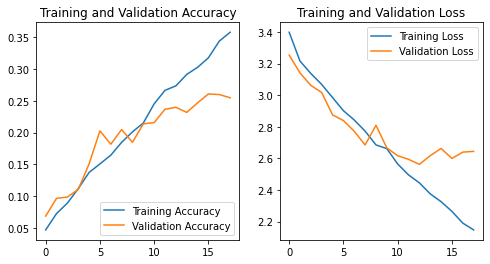

Wall time: 6.01 s


In [16]:
%%time
img_shape = img_dims(2,3)
CNN1_01 = CNN1(img_shape, filters= [32,64,128], dense = [512,512], classes = num_class)
CNN1_01 , score_CNN1_01 = fit_model(CNN1_01, 'CNN1_01', img_shape, image_gen_train , image_gen_test)

<p STYLE="padding-left:1em ; color:blue;text-align: justify;"><b> CNN avec des couches de batchnormalization

(192, 220, 3)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 192, 220, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 96, 110, 32)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 96, 110, 64)       18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 48, 55, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 48, 55, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 24,

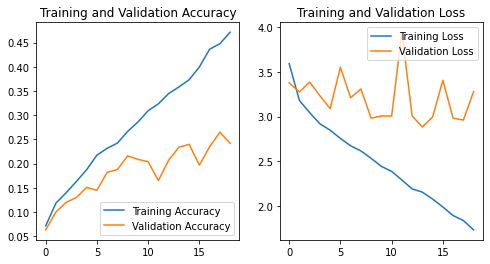

Wall time: 4.49 s


In [17]:
%%time
img_shape = img_dims(2,3)
CNN_BN_01 = CNN_BN(img_shape, filters= [32,64,128], dense = [512,512], classes = num_class)
CNN_BN_01 , score_CNN_BN_01 = fit_model(CNN_BN_01, 'CNN_BN_01', img_shape, image_gen_train , image_gen_test)

<p STYLE="padding-left:1em ; color:blue;text-align: justify;"><b> CNN avec des couches de dropout

(192, 220, 3)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 192, 220, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 96, 110, 32)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 96, 110, 64)       18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 48, 55, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 48, 55, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 24,

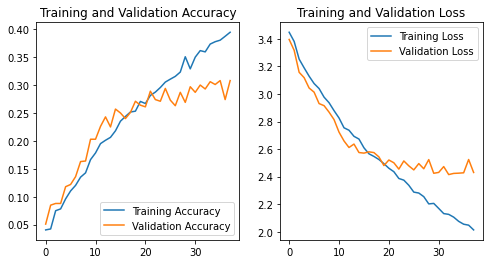

Wall time: 4.63 s


In [18]:
%%time
img_shape = img_dims(2,3)
CNN_DP_01 = CNN_DP(img_shape, filters= [32,64,128], dense = [512,512], classes = num_class)
CNN_DP_01 , score_CNN_DP_01 = fit_model(CNN_DP_01, 'CNN_DP_01', img_shape, image_gen_train , image_gen_test)

<p STYLE="padding-left:1em ; color:blue;text-align: justify;"><b> CNN avec les couches de dropout et batchnormalization

(192, 220, 3)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 192, 220, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 96, 110, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 96, 110, 64)       18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 48, 55, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 48, 55, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 24,

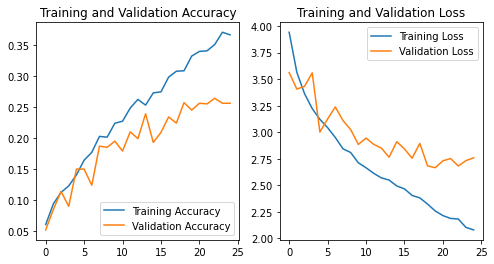

Wall time: 4.7 s


In [19]:
%%time
img_shape = img_dims(2,3)
CNN2_01 = CNN2(img_shape, filters= [32,64,128], dense = [512,512], classes = num_class)
CNN2_01 , score_CNN2_01 = fit_model(CNN2_01, 'CNN2_01', img_shape, image_gen_train , image_gen_test)

(192, 220, 3)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 192, 220, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 96, 110, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 96, 110, 64)       18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 48, 55, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 48, 55, 128)       73856     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 24,

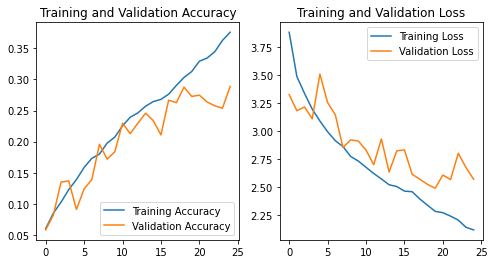

Wall time: 4.61 s


In [20]:
%%time
img_shape = img_dims(2,3)
CNN3_01 = CNN3(img_shape, filters= [32,64,128], dense = [512,512], classes = num_class)
CNN3_01 , score_CNN3_01 = fit_model(CNN3_01, 'CNN3_01', img_shape, image_gen_train , image_gen_test)

<p STYLE="padding-left:1em ; color:blue;text-align: justify;"><b> test avec une taille d'image plus faible en entrée de modèle

(128, 147, 3)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 128, 147, 32)      896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 64, 73, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 64, 73, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 32, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 32, 36, 128)       73856     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 16,

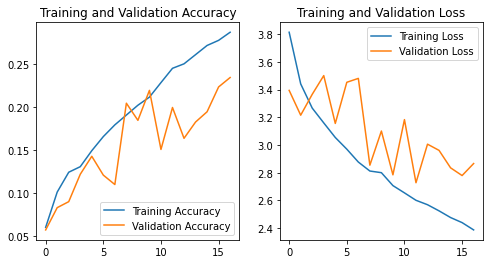

Wall time: 2.93 s


In [21]:
%%time
img_shape = img_dims(3,3)
CNN3_01_bis = CNN3(img_shape, filters= [32,64,128], dense = [512,512], classes = num_class)
CNN3_01_bis , score_CNN3_01_bis = fit_model(CNN3_01_bis, 'CNN3_01_bis', img_shape, image_gen_train , image_gen_test)

(192, 220, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 192, 220, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 96, 110, 64)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 110, 128)      73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 55, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 55, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 2

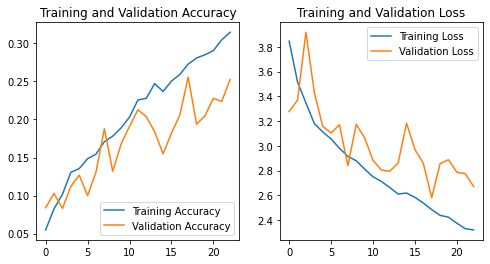

Wall time: 7.85 s


In [22]:
%%time
img_shape = img_dims(2,3)
CNN3_02 = CNN3(img_shape, filters= [64,128,256], dense = [512,512], classes = num_class)
CNN3_02 , score_CNN3_02 = fit_model(CNN3_02, 'CNN3_02', img_shape, image_gen_train , image_gen_test)

(192, 220, 3)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 192, 220, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 96, 110, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 96, 110, 64)       18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 48, 55, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 48, 55, 128)       73856     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 24,

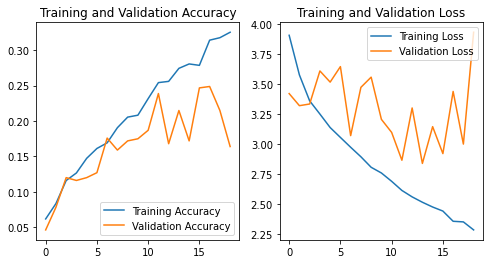

Wall time: 8.1 s


In [23]:
%%time
img_shape = img_dims(2,3)
CNN3_03 = CNN3(img_shape, filters= [32,64,128], dense = [1024,1024], classes = num_class)
CNN3_03 , score_CNN3_03 = fit_model(CNN3_03, 'CNN3_03', img_shape, image_gen_train , image_gen_test)

(192, 220, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 192, 220, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 96, 110, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 110, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 55, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 55, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 2

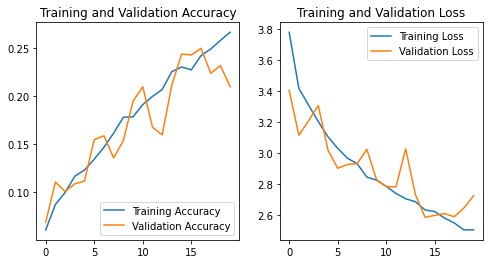

Wall time: 3.61 s


In [24]:
%%time
img_shape = img_dims(2,3)
CNN3_04 = CNN3(img_shape, filters= [32,64,128], dense = [256,256], classes = num_class)
CNN3_04 , score_CNN3_04 = fit_model(CNN3_04, 'CNN3_04', img_shape, image_gen_train , image_gen_test)

(192, 220, 3)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 192, 220, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 96, 110, 32)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 96, 110, 64)       18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 48, 55, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 48, 55, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 24,

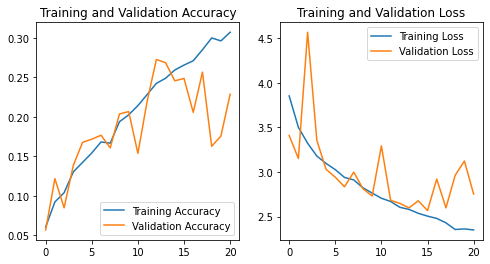

Wall time: 3.09 s


In [25]:
%%time
img_shape = img_dims(2,3)
CNN3_05 = CNN3(img_shape, filters= [32,64,128,256], dense = [512,512], classes = num_class)
CNN3_05 , score_CNN3_05 = fit_model(CNN3_05, 'CNN3_05', img_shape, image_gen_train , image_gen_test)

(192, 220, 3)
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_65 (Conv2D)          (None, 192, 220, 32)      896       
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 96, 110, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_66 (Conv2D)          (None, 96, 110, 64)       18496     
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 48, 55, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_67 (Conv2D)          (None, 48, 55, 128)       73856     
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 24

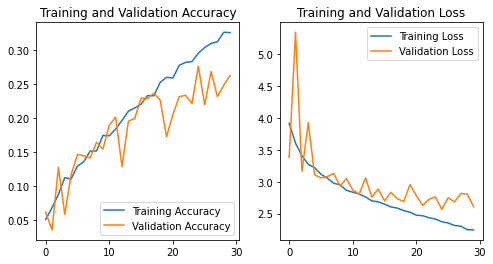

Wall time: 5.15 s


In [26]:
%%time
img_shape = img_dims(2,3)
CNN3_06 = CNN3(img_shape, filters= [32,64,128], dense = [512,512,512], classes = num_class)
CNN3_06 , score_CNN3_06 = fit_model(CNN3_06, 'CNN3_06', img_shape, image_gen_train , image_gen_test)

(192, 220, 3)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 192, 220, 64)      1792      
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 96, 110, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_53 (Conv2D)          (None, 96, 110, 128)      73856     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 48, 55, 128)      0         
 g2D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 337920)            0         
                                                                 
 batch_normalization_19 (Bat  (None, 337

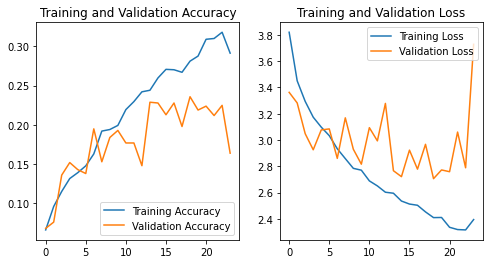

Wall time: 15.1 s


In [27]:
%%time
img_shape = img_dims(2,3)
CNN3_07 = CNN3(img_shape, filters= [64,128], dense = [512,512], classes = num_class)
CNN3_07 , score_CNN3_07 = fit_model(CNN3_07, 'CNN3_07', img_shape, image_gen_train , image_gen_test)

(192, 220, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 192, 220, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 96, 110, 64)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 110, 128)      73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 55, 128)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 337920)            0         
                                                                 
 batch_normalization (BatchN  (None, 33792

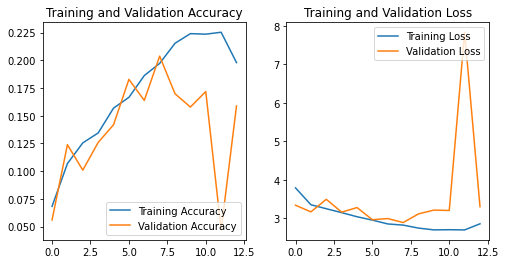

Wall time: 14.3 s


In [28]:
%%time
img_shape = img_dims(2,3)
CNN3_08 = CNN3(img_shape, filters= [64,128], dense = [512], classes = num_class)
CNN3_08 , score_CNN3_08 = fit_model(CNN3_08, 'CNN3_08', img_shape, image_gen_train , image_gen_test)

(192, 220, 3)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 192, 220, 128)     3584      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 96, 110, 128)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 110, 256)      295168    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 48, 55, 256)      0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 675840)            0         
                                                                 
 batch_normalization_2 (Batc  (None, 675

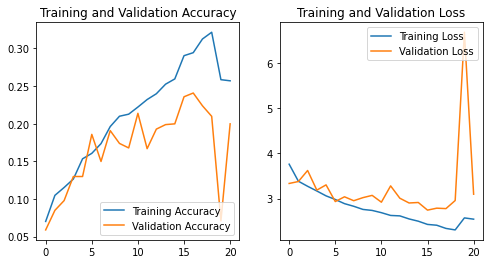

Wall time: 43.4 s


In [29]:
%%time
img_shape = img_dims(2,3)
CNN3_09 = CNN3(img_shape, filters= [128,256], dense = [512], classes = num_class)
CNN3_09 , score_CNN3_09 = fit_model(CNN3_09, 'CNN3_09', img_shape, image_gen_train , image_gen_test)

(192, 220, 3)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 192, 220, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 96, 110, 64)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 96, 110, 128)      73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 48, 55, 128)      0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 337920)            0         
                                                                 
 batch_normalization_4 (Batc  (None, 337

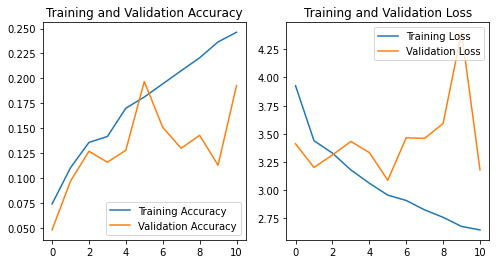

Wall time: 45.8 s


In [30]:
%%time
img_shape = img_dims(2,3)
CNN3_10 = CNN3(img_shape, filters= [64,128], dense = [1024], classes = num_class)
CNN3_10 , score_CNN3_10 = fit_model(CNN3_10, 'CNN3_10', img_shape, image_gen_train , image_gen_test)

(192, 220, 3)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 190, 216, 128)     3584      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 95, 108, 128)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 95, 108, 256)      295168    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 47, 54, 256)      0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 649728)            0         
                                                                 
 batch_normalization_4 (Batc  (None, 649

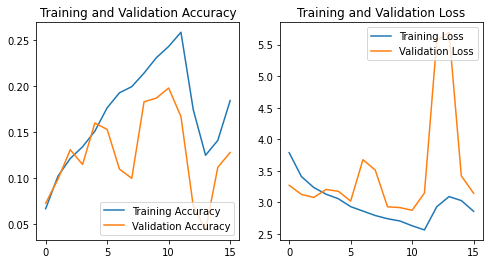

Wall time: 1min 3s


In [31]:
%%time
img_shape = img_dims(2,3)
CNN3_11 = CNN3(img_shape, filters= [128,256], dense = [512], classes = num_class)
CNN3_11 , score_CNN3_11 = fit_model(CNN3_11, 'CNN3_11', img_shape, image_gen_train , image_gen_test)

## <a STYLE="padding-left:1em;color:black" id="3.1.2">3.1.2 Reconstitution d'un modèle existant : VGG16</a> 
<p STYLE="padding-left:1em ; color:blue;text-align: justify;"><b> Dans cette section, nous allons tester un modèle de réseau de neurones convolutifs existant (VGG16) en ajoutant pour certains modèles des couches de dropout et/ou de batchnormalization

In [32]:
def vgg_16(img_shape,classes=120, batch = True , dropout = True , test = True):
    model = Sequential()

    # Couche de convolution + pooling 
    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=img_shape, activation='relu',padding="SAME"))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu',padding="SAME"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu',padding="SAME"))
    model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu',padding="SAME"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu',padding="SAME"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu',padding="SAME"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu',padding="SAME"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu',padding="SAME"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu',padding="SAME"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu',padding="SAME"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu',padding="SAME"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu',padding="SAME"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu',padding="SAME"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    
    model.add(Flatten())
    model.add(BatchNormalization()) if batch == True else None
    
    if test == True : 
        model.add(Dense(4096, activation='relu'))
        model.add(Dropout(0.3)) if dropout == True else None
        model.add(BatchNormalization()) if batch == True else None

        model.add(Dense(4096, activation='relu'))
        model.add(Dropout(0.3)) if dropout == True else None
        model.add(BatchNormalization()) if batch == True else None
    else : 
        model.add(Dense(4096, activation='relu'))
        model.add(BatchNormalization()) if batch == True else None
        model.add(Dropout(0.3)) if dropout == True else None
        
        model.add(Dense(4096, activation='relu'))
        model.add(BatchNormalization()) if batch == True else None
        model.add(Dropout(0.3)) if dropout == True else None
        
    model.add(Dense(classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

#     model.summary()
    return model

<p STYLE="padding-left:1em ; color:blue;text-align: justify;"><b> Modèle sans les couches de <span STYLE="color:gray;"><i> Dropout & Batchnormalization </i></span>

(192, 220, 3)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 192, 220, 64)      1792      
                                                                 
 conv2d_14 (Conv2D)          (None, 192, 220, 64)      36928     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 96, 110, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 96, 110, 128)      73856     
                                                                 
 conv2d_16 (Conv2D)          (None, 96, 110, 128)      147584    
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 48, 55, 128)      0         
 g2D)                                   

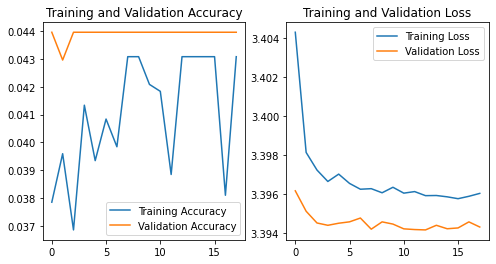

Wall time: 11.9 s


In [33]:
%%time
img_shape = img_dims(2,3)
vgg_16_01 = vgg_16(img_shape, classes=num_class, batch = False , dropout = False, test=True)
vgg_16_01 , score_vgg_16_01 = fit_model(vgg_16_01, 'vgg_16_01', img_shape, image_gen_train , image_gen_test)

<p STYLE="padding-left:1em ; color:blue;text-align: justify;"><b> Modèle avec des couches de <span STYLE="color:gray;"><i> Dropout & Batchnormalization </i></span>

(192, 220, 3)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 192, 220, 64)      1792      
                                                                 
 conv2d_27 (Conv2D)          (None, 192, 220, 64)      36928     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 96, 110, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 96, 110, 128)      73856     
                                                                 
 conv2d_29 (Conv2D)          (None, 96, 110, 128)      147584    
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 48, 55, 128)      0         
 g2D)                                   

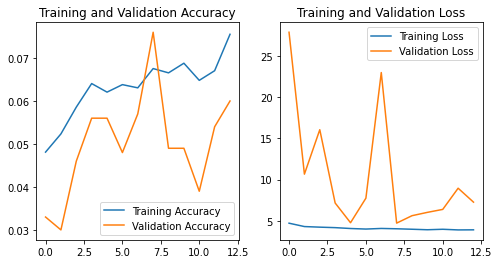

Wall time: 14.6 s


In [34]:
%%time
img_shape = img_dims(2,3)
vgg_16_02 = vgg_16(img_shape, classes=num_class, batch = True , dropout = True, test=True)
vgg_16_02 , score_vgg_16_02 = fit_model(vgg_16_02, 'vgg_16_02', img_shape, image_gen_train , image_gen_test)

<p STYLE="padding-left:1em ; color:blue;text-align: justify;"><b> Modèle avec les couches de <span STYLE="color:gray;"><i> Batchnormalization & Dropout </i></span>

(192, 220, 3)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 192, 220, 64)      1792      
                                                                 
 conv2d_40 (Conv2D)          (None, 192, 220, 64)      36928     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 96, 110, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 96, 110, 128)      73856     
                                                                 
 conv2d_42 (Conv2D)          (None, 96, 110, 128)      147584    
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 48, 55, 128)      0         
 g2D)                                   

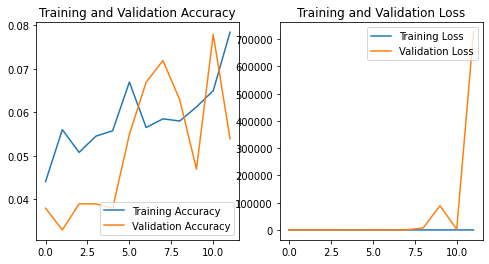

Wall time: 12.2 s


In [35]:
%%time
img_shape = img_dims(2,3)
vgg_16_03 = vgg_16(img_shape, classes=num_class, batch = True , dropout = True, test=False)
vgg_16_03 , score_vgg_16_03 = fit_model(vgg_16_03, 'vgg_16_03', img_shape, image_gen_train , image_gen_test)

<p STYLE="padding-left:1em ; color:blue;text-align: justify;"><b> Nous observons que les différents tests menés avec le modèle existant VGG16 et un jeu de donnée réduit donne de mauvais résultat en terme de prédiction

## <a STYLE="color:black" id="3.2">3.2 Jeu de donnée complet</a> 
## <a STYLE="padding-left:1em;color:black" id="3.2.1">3.2.1 Modèle VGG16 reconstitué</a> 

In [36]:
path_dir = repertory+'/Dataset_120/' 

train_path = path_dir+'train_set'
val_path = path_dir+'val_set'
test_path = path_dir+'test_set'
pred_path = path_dir+'pred_set'

total_img_train = 0
total_img_test = 0
batch_size = 32
num_class = 120

for root, dirs, files in os.walk(train_path):
    total_img_train += len(files)

for root, dirs, files in os.walk(val_path):
    total_img_test += len(files)

print(total_img_train,total_img_test)

steps_per_epoch_train = round(total_img_train/batch_size+0.5)
steps_per_epoch_test = round(total_img_test /batch_size+0.5)
print(steps_per_epoch_train,steps_per_epoch_test)

16376 4085
512 128


(192, 220, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 192, 220, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 192, 220, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 96, 110, 64)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 110, 128)      73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 110, 128)      147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 55, 128)      0         
 2D)                                      

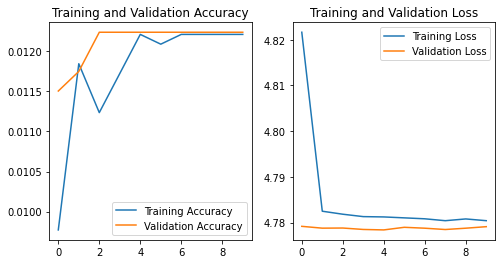

Wall time: 12.4 s


In [37]:
%%time
img_shape = img_dims(2,3)
vgg_16_01_120 = vgg_16(img_shape, classes=num_class, batch = False , dropout = False, test=True)
vgg_16_01_120 , score_vgg_16_01_120 = fit_model(vgg_16_01_120, 'vgg_16_01_120', img_shape, image_gen_train , image_gen_test)

(192, 220, 3)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 192, 220, 64)      1792      
                                                                 
 conv2d_14 (Conv2D)          (None, 192, 220, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 96, 110, 64)      0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 96, 110, 128)      73856     
                                                                 
 conv2d_16 (Conv2D)          (None, 96, 110, 128)      147584    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 48, 55, 128)      0         
 2D)                                    

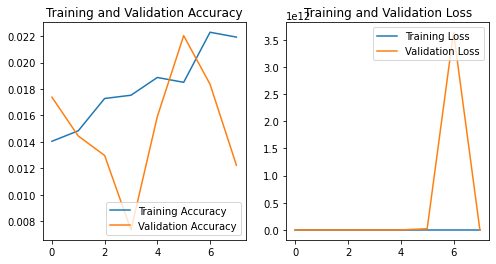

Wall time: 12.3 s


In [38]:
%%time
img_shape = img_dims(2,3)
vgg_16_02_120 = vgg_16(img_shape, classes=num_class, batch = True , dropout = True, test=True)
vgg_16_02_120 , score_vgg_16_02_120 = fit_model(vgg_16_02_120, 'vgg_16_02_120', img_shape, image_gen_train , image_gen_test)

(192, 220, 3)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 192, 220, 64)      1792      
                                                                 
 conv2d_27 (Conv2D)          (None, 192, 220, 64)      36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 96, 110, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 96, 110, 128)      73856     
                                                                 
 conv2d_29 (Conv2D)          (None, 96, 110, 128)      147584    
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 48, 55, 128)      0         
 g2D)                                   

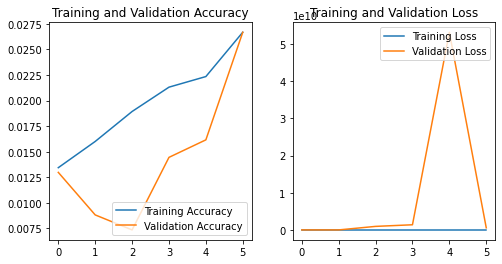

Wall time: 14.7 s


In [39]:
%%time
img_shape = img_dims(2,3)
vgg_16_03_120 = vgg_16(img_shape, classes=num_class, batch = True , dropout = True, test=False)
vgg_16_03_120 , score_vgg_16_03_120 = fit_model(vgg_16_03_120, 'vgg_16_03_120', img_shape, image_gen_train , image_gen_test)

<p STYLE="padding-left:1em ; color:blue;text-align: justify;"><b> Nous observons que l'utilisation du jeu de donnée complet ne permet pas d'améliorer les prédictions. Ce faible score est probablement dû au nombre insuffisant d'image par race de chien pour l'entrainement du modèle.


# <a STYLE="color:black" id="4">Etape 4 : Transfert learning</a> 
<p STYLE="padding-left:1em ; color:blue;text-align: justify;"><b> Dans cette partie, nous allons utiliser des modèles pré-entrainés sur ImageNet avec un jeu de donnée plus imprtant que celui de notre étude (issus également d'ImageNet) afin d'obtenir de meilleurs résultats.</b></p>

## <a STYLE="color:black" id="4.1">4.1 Modèle VGG16</a> 

In [40]:
def process_models(model_inputs, predictions , preprocess_input ) : 
    
    model = keras.Model(inputs=model_inputs.input, outputs=predictions)
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

    image_gen_train = ImageDataGenerator(rotation_range=30, 
                               width_shift_range=0.10, 
                               height_shift_range=0.10, 
                               shear_range=0.2, 
                               zoom_range=0.2, 
                               horizontal_flip=True, 
                               preprocessing_function=preprocess_input)

    image_gen_test = ImageDataGenerator(preprocessing_function=preprocess_input )
    return model, image_gen_train ,image_gen_test


def test_model(model , img_shape ):
    image_gen_test= ImageDataGenerator(rotation_range=30, 
                               width_shift_range=0.10, 
                               height_shift_range=0.10, 
                               shear_range=0.2, 
                               zoom_range=0.2, 
                               horizontal_flip=True, 
                               preprocessing_function=preprocess_input)
    test_generator  = image_gen_test.flow_from_directory(test_path,target_size=img_shape[:2],color_mode='rgb',
                                                                   batch_size=batch_size,class_mode='categorical', 
                                                                   shuffle = False)
    model.evaluate(test_generator)

In [41]:
path_dir = repertory+'/Dataset_120/' 

train_path = path_dir+'train_set'
test_path = path_dir+'test_set'
val_path = path_dir+'val_set'
pred_path = path_dir+'pred_set'

total_img_train = 0
total_img_test = 0
batch_size = 32
num_class = 120

classes = ImageDataGenerator().flow_from_directory(train_path).class_indices
classes = {v: k for k, v in classes.items()}
dump(classes , models_path+'classes_120.joblib',compress = True)

for root, dirs, files in os.walk(train_path):
    total_img_train += len(files)

for root, dirs, files in os.walk(val_path):
    total_img_test += len(files)

print(total_img_train,total_img_test)

steps_per_epoch_train = round(total_img_train/batch_size+0.5)
steps_per_epoch_test = round(total_img_test /batch_size+0.5)
print(steps_per_epoch_train,steps_per_epoch_test)

Found 16376 images belonging to 120 classes.
16376 4085
512 128


<p STYLE="padding-left:1em ; color:blue;text-align: justify;"><b>Ce modèle s'étant entrainé avec le jeu de donnée issue d'ImageNet, nous pouvons considérer que les caractéristiques relatives au race de chien ont été apprises lors de son entrainement. Nous pouvons ainsi geler les couches convolutives. Par contre, pour les couches totalements connectées, où nous avons une couche de sortie comportant 1000 classes, il est necessaire de les re-entrainer afin de les adapter à notre étude qui se concentre seulement sur les races de chien (120 classes) <b></p> 

In [42]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions

img_shape = (224,224,3)
decode_predictions_vgg16 = decode_predictions
preprocess_input_vgg16 = preprocess_input

model_base_vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=img_shape)
model_base_vgg16.trainable = False
model_base_vgg16.summary()

x_vgg16 = keras.layers.Flatten()(model_base_vgg16.output)
x_vgg16 = keras.layers.Dense(4096, activation='relu')(x_vgg16)
x_vgg16 = keras.layers.Dense(4096, activation='relu')(x_vgg16)
predictions_vgg16 = keras.layers.Dense(num_class, activation = 'softmax')(x_vgg16)

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

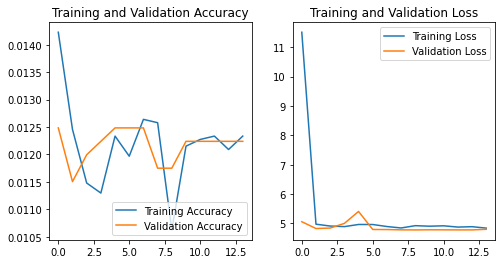

Wall time: 9.11 s


In [43]:
%%time
model_vgg16 ,image_gen_train_vgg16 , image_gen_test_vgg16 = process_models(model_base_vgg16, predictions_vgg16, 
                                                                            preprocess_input_vgg16 )

img_shape = (224,224,3)
transfert_vgg16 , score_transfert_vgg16 = fit_model(model_vgg16, 'transfert_vgg16', img_shape,
                                                    image_gen_train_vgg16 , image_gen_test_vgg16)

<p STYLE="padding-left:1em ; color:blue;text-align: justify;"><b> L'utilisation du modèle VVG16 ou nous entrainons les 3 dernères couches de neurones et la couche de "flatenning" ne permet d'obtenir de bonnes prédictions. Nous allons ajouter des couches de<span STYLE="color:gray;"><i> Dropout & Batchnormalization </i></span> afin d'essayer d'améliorer les résultats. 

In [44]:
img_shape = (224,224,3)
new_imput = keras.Input(shape=(224,224,3))

model_base_vgg16_02 = VGG16(weights="imagenet", include_top=False,input_tensor=new_imput ,input_shape=img_shape )
model_base_vgg16_02.trainable = False
model_base_vgg16_02.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [45]:
x_vgg16_02 = keras.layers.Flatten()(model_base_vgg16_02.output)
x_vgg16_02 = keras.layers.Dense(4096, activation='relu')(x_vgg16_02)
x_vgg16_02 = keras.layers.Dropout(0.3)(x_vgg16_02)
x_vgg16_02 = keras.layers.Dense(4096, activation='relu')(x_vgg16_02)
x_vgg16_02 = keras.layers.Dropout(0.3)(x_vgg16_02)
predictions_vgg16_02 = Dense(num_class, activation='softmax')(x_vgg16_02)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

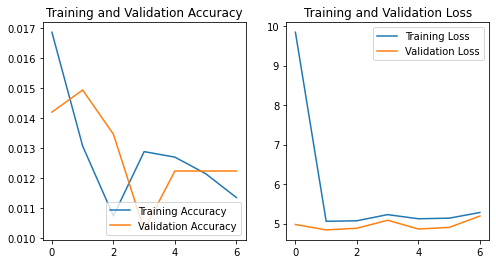

Wall time: 9.19 s


In [46]:
%%time
model_vgg16_02 ,image_gen_train_vgg16_02, image_gen_test_vgg16_02 = process_models(model_base_vgg16_02,predictions_vgg16_02, preprocess_input_vgg16 )

img_shape = (224,224,3)
transfert_vgg16_02 , score_transfert_vgg16_02 = fit_model(model_vgg16_02, 'transfert_vgg16_02', img_shape,
                                                          image_gen_train_vgg16_02 , image_gen_test_vgg16_02)

<p STYLE="padding-left:1em ; color:blue;text-align: justify;"><b> L'ajout des couches de <span STYLE="color:gray;"><i> Dropout & Batchnormalization </i></span> ne permet pas d'améliorer les prédictions. <br>
Nous allons par la suite, utiliser le modèle vgg16 entièrement entrainé, où nous supprimons les deux dernières couches de neurones. 

In [47]:
model_base_vgg16_03 = VGG16(weights="imagenet", include_top=True )
model_base_vgg16_03 = Sequential(model_base_vgg16_03.layers[:-2])

model_base_vgg16_03.trainable = False
model_base_vgg16_03.summary()

x_vgg16_03 = keras.layers.Dense(4096, activation='relu')(model_base_vgg16_03.output)
predictions_vgg16_03 = Dense(num_class, activation='softmax')(x_vgg16_03)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

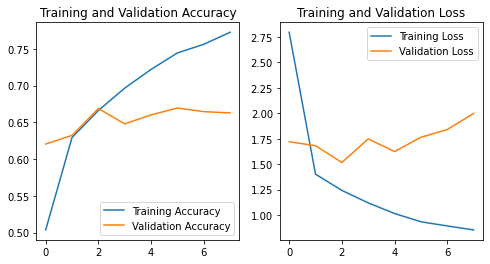

Wall time: 5.91 s


In [48]:
%%time
model_vgg16_03 ,image_gen_train_vgg16_03, image_gen_test_vgg16_03 = process_models(model_base_vgg16_03,predictions_vgg16_03, preprocess_input_vgg16 )

img_shape = (224,224,3)
transfert_vgg16_03 , score_transfert_vgg16_03 = fit_model(model_vgg16_03, 'transfert_vgg16_03', img_shape,
                                                          image_gen_train_vgg16_03 , image_gen_test_vgg16_03)

<p STYLE="padding-left:1em ; color:blue;text-align: justify;"><b> Nous observons une forte amélioration des prédictions en n'entrainant que les deux dernières couches de neurones. Cependant, nous observons un surapprentissage du modèle, nous allons ajouter des couches de<span STYLE="color:gray;"><i> Dropout </i></span>  afin de limier le sur-apprentissage.

In [49]:
model_base_vgg16_04 = VGG16(weights="imagenet", include_top=True )
model_base_vgg16_04 = Sequential(model_base_vgg16_04.layers[:-2])

model_base_vgg16_04.trainable = False
model_base_vgg16_04.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [50]:
x_vgg16_04 = keras.layers.Dropout(0.3)(model_base_vgg16_04.output)
x_vgg16_04 = keras.layers.Dense(4096, activation='relu')(x_vgg16_04)
x_vgg16_04 = keras.layers.Dropout(0.3)(x_vgg16_04)
predictions_vgg16_04 = Dense(num_class, activation='softmax')(x_vgg16_04)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

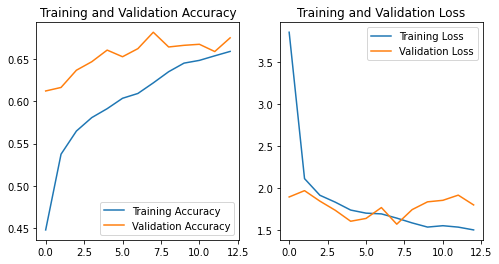

Wall time: 5.78 s


In [51]:
%%time
model_vgg16_04 ,image_gen_train_vgg16_04, image_gen_test_vgg16_04 = process_models(model_base_vgg16_04,predictions_vgg16_04, preprocess_input_vgg16 )

img_shape = (224,224,3)
transfert_vgg16_04 , score_transfert_vgg16_04 = fit_model(model_vgg16_04, 'transfert_vgg16_04', img_shape,
                                                          image_gen_train_vgg16_04 , image_gen_test_vgg16_04)

<p STYLE="padding-left:1em ; color:blue;text-align: justify;"><b> L'ajout des couches de <span STYLE="color:gray;"><i> Dropout </i></span> a permis de limier le sur-apprentissage. Nous allons ajouter des couches de <span STYLE="color:gray;"><i> Batchnormalization </i></span> afin d'essayer d'améliorer les prédictions 

In [52]:
model_base_vgg16_05 = VGG16(weights="imagenet", include_top=True )
model_base_vgg16_05 = Sequential(model_base_vgg16_05.layers[:-2])

model_base_vgg16_05.trainable = False

x_vgg16_05 = keras.layers.BatchNormalization()(model_base_vgg16_05.output)
x_vgg16_05 = keras.layers.Dropout(0.3)(x_vgg16_05)
x_vgg16_05 = keras.layers.Dense(4096, activation='relu')(x_vgg16_05)
x_vgg16_05 = keras.layers.BatchNormalization()(x_vgg16_05)
x_vgg16_05 = keras.layers.Dropout(0.3)(x_vgg16_05)
predictions_vgg16_05 = Dense(num_class, activation='softmax')(x_vgg16_05)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

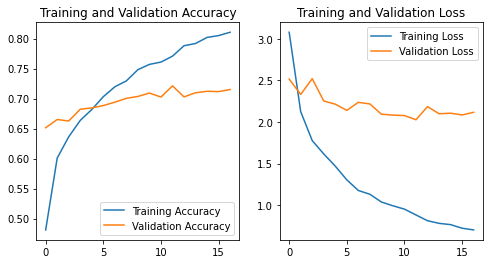

Wall time: 5.95 s


In [53]:
%%time
model_vgg16_05 ,image_gen_train_vgg16_05, image_gen_test_vgg16_05 = process_models(model_base_vgg16_05,predictions_vgg16_05, preprocess_input_vgg16 )

img_shape = (224,224,3)
transfert_vgg16_05 , score_transfert_vgg16_05 = fit_model(model_vgg16_05, 'transfert_vgg16_05', img_shape,
                                                          image_gen_train_vgg16_05 , image_gen_test_vgg16_05)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

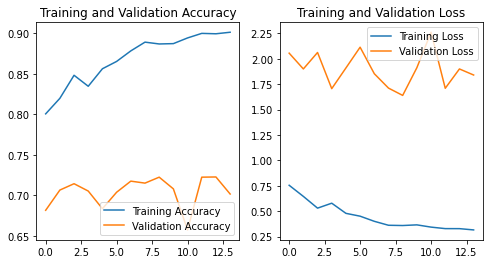

Wall time: 10.9 s


In [54]:
%%time
model_base_vgg16_05.trainable = True
transfert_vgg16_05.compile(optimizer=keras.optimizers.Adam(1e-5),# Low learning rate
                    loss='categorical_crossentropy',metrics=['accuracy'])


img_shape = (224,224,3)
transfert_vgg16_ajust_05 , score_transfert_vgg16_ajust_05 = fit_model(transfert_vgg16_05, 'transfert_vgg16_ajust_05', 
                                                                            img_shape,image_gen_train_vgg16_05 , 
                                                                            image_gen_test_vgg16_05)

<p STYLE="padding-left:1em ; color:blue;text-align: justify;"><b> L'ajout des couches de <span STYLE="color:gray;"><i> Batchnormalization </i></span> améliore les prédictions, elle s'accompagne d'un sur-apprentissage du modèle. 

## <a STYLE="color:black" id="4.2">4.2 Modèle Xception</a> 

In [55]:
from keras.applications.xception import Xception , preprocess_input,  decode_predictions
img_shape = (299,299,3)
new_imput = keras.Input(shape=(299,299,3))

preprocess_input_xception = preprocess_input
decode_predictions_xception = decode_predictions

model_base_xception = Xception(weights="imagenet", include_top=False,input_tensor=new_imput,input_shape=img_shape )
model_base_xception.trainable = False
model_base_xception.summary()

x_xception = GlobalAveragePooling2D()(model_base_xception.output)
predictions_xception = Dense(num_class, activation='softmax')(x_xception)

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

 block4_sepconv1_bn (BatchNorma  (None, 37, 37, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 37, 37, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 37, 37, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 37, 37, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 19, 19, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 19, 19, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 19, 19, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 19, 19, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_7 (Add)                    (None, 19, 19, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_6[0][0]']                  
                                                                                                  
 block10_sepconv1_act (Activati  (None, 19, 19, 728)  0          ['add_7[0][0]']                  
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 19, 19, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 19, 19, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 19, 19, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 19, 19, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_10 (A

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

 block4_sepconv1_bn (BatchNorma  (None, 37, 37, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 37, 37, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 37, 37, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 37, 37, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 19, 19, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 19, 19, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 19, 19, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 19, 19, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_19 (Add)                   (None, 19, 19, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_18[0][0]']                 
                                                                                                  
 block10_sepconv1_act (Activati  (None, 19, 19, 728)  0          ['add_19[0][0]']                 
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 19, 19, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 19, 19, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 19, 19, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 19, 19, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_22 (A

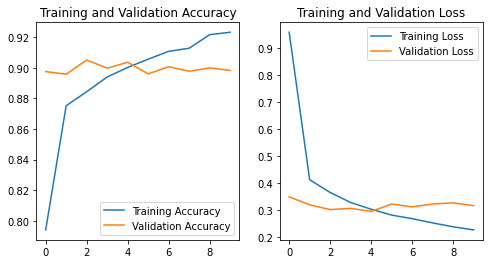

Wall time: 4.92 s


In [56]:
%%time
model_xception ,image_gen_train_xception, image_gen_test_xception = process_models(model_base_xception, 
                                                                                   predictions_xception , 
                                                                                   preprocess_input_xception )

img_shape = (299,299,3)
transfert_xception , score_transfert_xception = fit_model(model_xception, 'transfert_xception', img_shape,
                                                          image_gen_train_xception , image_gen_test_xception)

<p STYLE="padding-left:1em ; color:blue;text-align: justify;"><b> Nous observons de bonnes prédictions avec ce modèle. Cependant nous notons un léger sur-apprentissage.

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

 block4_sepconv1_bn (BatchNorma  (None, 37, 37, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 37, 37, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 37, 37, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 37, 37, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 19, 19, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 19, 19, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 19, 19, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 19, 19, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_19 (Add)                   (None, 19, 19, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_18[0][0]']                 
                                                                                                  
 block10_sepconv1_act (Activati  (None, 19, 19, 728)  0          ['add_19[0][0]']                 
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 19, 19, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 19, 19, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 19, 19, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 19, 19, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_22 (A

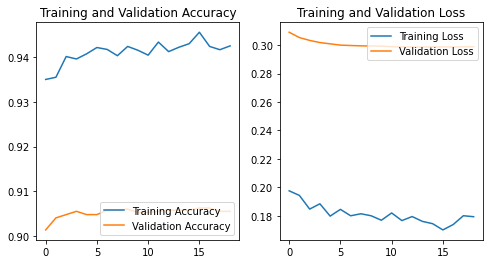

Wall time: 3.29 s


In [57]:
%%time
model_base_xception.trainable = True
transfert_xception.compile(optimizer=keras.optimizers.Adam(1e-5),# Low learning rate
                    loss='categorical_crossentropy',metrics=['accuracy'])

img_shape = (299,299,3)
transfert_xception_ajust , score_transfert_xception_ajust = fit_model(transfert_xception, 'transfert_xception_ajust', 
                                                                      img_shape,image_gen_train_xception , 
                                                                      image_gen_test_xception)

<p STYLE="padding-left:1em ; color:blue;text-align: justify;"><b> L'entrainement fin du modèle ne permet pas d'améliorer les prédictions où nous voyons une hausse du sur-apprentissage. Pour limiter cela, nous allons ajouter des couches de <span STYLE="color:gray;"><i> Dropout</i></span>

In [58]:
model_base_xception_02 = Xception(weights="imagenet", include_top=False,input_tensor=new_imput,input_shape=img_shape )
model_base_xception_02.trainable = False
model_base_xception_02.summary()

x_xception_02 = GlobalAveragePooling2D()(model_base_xception_02.output)
x_xception_02 = keras.layers.Dropout(0.3)(x_xception_02)
predictions_xception_02 = Dense(num_class, activation='softmax')(x_xception_02)

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

 block4_sepconv1_bn (BatchNorma  (None, 37, 37, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 37, 37, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 37, 37, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 37, 37, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 19, 19, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 19, 19, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 19, 19, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 19, 19, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_19 (Add)                   (None, 19, 19, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_18[0][0]']                 
                                                                                                  
 block10_sepconv1_act (Activati  (None, 19, 19, 728)  0          ['add_19[0][0]']                 
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 19, 19, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 19, 19, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 19, 19, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 19, 19, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_22 (A

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

 block4_sepconv1_bn (BatchNorma  (None, 37, 37, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 37, 37, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 37, 37, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 37, 37, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 19, 19, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 19, 19, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 19, 19, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 19, 19, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_55 (Add)                   (None, 19, 19, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_54[0][0]']                 
                                                                                                  
 block10_sepconv1_act (Activati  (None, 19, 19, 728)  0          ['add_55[0][0]']                 
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 19, 19, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 19, 19, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 19, 19, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 19, 19, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_58 (A

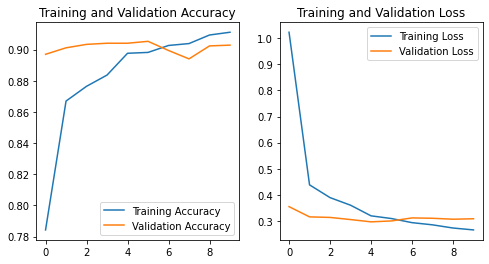

Wall time: 3.96 s


In [59]:
%%time
model_xception_02 ,image_gen_train_xception_02, image_gen_test_xception_02 = process_models(model_base_xception_02,predictions_xception_02, preprocess_input_xception )

img_shape = (299,299,3)
transfert_xception_02 , score_transfert_xception_02 = fit_model(model_xception_02, 'transfert_xception_02', img_shape,
                                                          image_gen_train_xception_02 , image_gen_test_xception_02)

<p STYLE="padding-left:1em ; color:blue;text-align: justify;"><b> L'ajout de la couche de <span STYLE="color:gray;"><i> Dropout </i></span> permet de limiter le sur-apprentissage.

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

 block4_sepconv1_bn (BatchNorma  (None, 37, 37, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 37, 37, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 37, 37, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 37, 37, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 19, 19, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 19, 19, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 19, 19, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 19, 19, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_55 (Add)                   (None, 19, 19, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_54[0][0]']                 
                                                                                                  
 block10_sepconv1_act (Activati  (None, 19, 19, 728)  0          ['add_55[0][0]']                 
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 19, 19, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 19, 19, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 19, 19, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 19, 19, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_58 (A

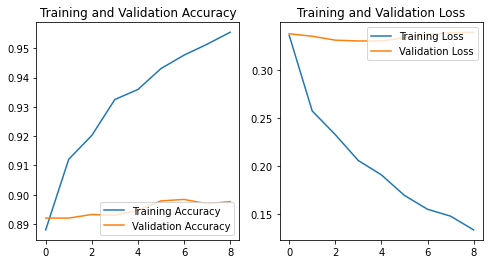

Wall time: 5.56 s


In [60]:
%%time
model_base_xception_02.trainable = True
transfert_xception_02.compile(optimizer=keras.optimizers.Adam(1e-5),# Low learning rate
                    loss='categorical_crossentropy',metrics=['accuracy'])

img_shape = (299,299,3)
transfert_xception_ajust_02 , score_transfert_xception_ajust_02 = fit_model(transfert_xception_02, 'transfert_xception_ajust_02', 
                                                                            img_shape,image_gen_train_xception_02 , 
                                                                            image_gen_test_xception_02)

<p STYLE="padding-left:1em ; color:blue;text-align: justify;"><b>Le réglage fin du modèle détériore le modèle par une hausse du sur-apprentissage. 


## <a STYLE="color:black" id="4.3">4.3 Modèle InceptionResNetV2</a> 

In [61]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2 , preprocess_input,  decode_predictions
img_shape = (299,299,3)
new_imput = keras.Input(shape=(299,299,3))

preprocess_input_InceptionResNetV2 = preprocess_input

model_base_InceptionResNetV2 = InceptionResNetV2(weights="imagenet", include_top=False,input_tensor=new_imput,input_shape=img_shape )
model_base_InceptionResNetV2.trainable = False
model_base_InceptionResNetV2.summary()

x_InceptionResNetV2 = GlobalAveragePooling2D()(model_base_InceptionResNetV2.output)
predictions_InceptionResNetV2 = Dense(num_class, activation='softmax')(x_InceptionResNetV2)

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                               

 batch_normalization_5 (BatchNo  (None, 35, 35, 96)  288         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 35, 35, 64)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_10 (BatchN  (None, 35, 35, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 35, 35, 64)  192         ['conv2d_11[0][0]']              
 ormalizat

 activation_21 (Activation)     (None, 35, 35, 32)   0           ['batch_normalization_21[0][0]'] 
                                                                                                  
 conv2d_19 (Conv2D)             (None, 35, 35, 32)   10240       ['block35_1_ac[0][0]']           
                                                                                                  
 conv2d_22 (Conv2D)             (None, 35, 35, 48)   13824       ['activation_21[0][0]']          
                                                                                                  
 batch_normalization_19 (BatchN  (None, 35, 35, 32)  96          ['conv2d_19[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_22 (BatchN  (None, 35, 35, 48)  144         ['conv2d_22[0][0]']              
 ormalizat

                                                                                                  
 activation_24 (Activation)     (None, 35, 35, 32)   0           ['batch_normalization_24[0][0]'] 
                                                                                                  
 activation_26 (Activation)     (None, 35, 35, 32)   0           ['batch_normalization_26[0][0]'] 
                                                                                                  
 activation_29 (Activation)     (None, 35, 35, 64)   0           ['batch_normalization_29[0][0]'] 
                                                                                                  
 block35_3_mixed (Concatenate)  (None, 35, 35, 128)  0           ['activation_24[0][0]',          
                                                                  'activation_26[0][0]',          
                                                                  'activation_29[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 batch_normalization_40 (BatchN  (None, 35, 35, 48)  144         ['conv2d_40[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_37 (Activation)     (None, 35, 35, 32)   0           ['batch_normalization_37[0][0]'] 
                                                                                                  
 activation_40 (Activation)     (None, 35, 35, 48)   0           ['batch_normalization_40[0][0]'] 
                                                                                                  
 conv2d_36 (Conv2D)             (None, 35, 35, 32)   10240       ['block35_4_ac[0][0]']           
          

 block35_6_mixed (Concatenate)  (None, 35, 35, 128)  0           ['activation_42[0][0]',          
                                                                  'activation_44[0][0]',          
                                                                  'activation_47[0][0]']          
                                                                                                  
 block35_6_conv (Conv2D)        (None, 35, 35, 320)  41280       ['block35_6_mixed[0][0]']        
                                                                                                  
 block35_6 (Lambda)             (None, 35, 35, 320)  0           ['block35_5_ac[0][0]',           
                                                                  'block35_6_conv[0][0]']         
                                                                                                  
 block35_6_ac (Activation)      (None, 35, 35, 320)  0           ['block35_6[0][0]']              
          

 activation_58 (Activation)     (None, 35, 35, 48)   0           ['batch_normalization_58[0][0]'] 
                                                                                                  
 conv2d_54 (Conv2D)             (None, 35, 35, 32)   10240       ['block35_7_ac[0][0]']           
                                                                                                  
 conv2d_56 (Conv2D)             (None, 35, 35, 32)   9216        ['activation_55[0][0]']          
                                                                                                  
 conv2d_59 (Conv2D)             (None, 35, 35, 64)   27648       ['activation_58[0][0]']          
                                                                                                  
 batch_normalization_54 (BatchN  (None, 35, 35, 32)  96          ['conv2d_54[0][0]']              
 ormalization)                                                                                    
          

                                                                  'block35_9_conv[0][0]']         
                                                                                                  
 block35_9_ac (Activation)      (None, 35, 35, 320)  0           ['block35_9[0][0]']              
                                                                                                  
 conv2d_69 (Conv2D)             (None, 35, 35, 32)   10240       ['block35_9_ac[0][0]']           
                                                                                                  
 batch_normalization_69 (BatchN  (None, 35, 35, 32)  96          ['conv2d_69[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_69 (Activation)     (None, 35, 35, 32)   0           ['batch_normalization_69[0][0]'] 
          

 activation_75 (Activation)     (None, 17, 17, 384)  0           ['batch_normalization_75[0][0]'] 
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 17, 17, 320)  0          ['block35_10_ac[0][0]']          
                                                                                                  
 mixed_6a (Concatenate)         (None, 17, 17, 1088  0           ['activation_72[0][0]',          
                                )                                 'activation_75[0][0]',          
                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_77 (Conv2D)             (None, 17, 17, 128)  139264      ['mixed_6a[0][0]']               
                                                                                                  
 batch_nor

                                )                                 'block17_2_conv[0][0]']         
                                                                                                  
 block17_2_ac (Activation)      (None, 17, 17, 1088  0           ['block17_2[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_85 (Conv2D)             (None, 17, 17, 128)  139264      ['block17_2_ac[0][0]']           
                                                                                                  
 batch_normalization_85 (BatchN  (None, 17, 17, 128)  384        ['conv2d_85[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

                                )                                                                 
                                                                                                  
 conv2d_93 (Conv2D)             (None, 17, 17, 128)  139264      ['block17_4_ac[0][0]']           
                                                                                                  
 batch_normalization_93 (BatchN  (None, 17, 17, 128)  384        ['conv2d_93[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_93 (Activation)     (None, 17, 17, 128)  0           ['batch_normalization_93[0][0]'] 
                                                                                                  
 conv2d_94 (Conv2D)             (None, 17, 17, 160)  143360      ['activation_93[0][0]']          
          

                                                                                                  
 batch_normalization_101 (Batch  (None, 17, 17, 128)  384        ['conv2d_101[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_101 (Activation)    (None, 17, 17, 128)  0           ['batch_normalization_101[0][0]']
                                                                                                  
 conv2d_102 (Conv2D)            (None, 17, 17, 160)  143360      ['activation_101[0][0]']         
                                                                                                  
 batch_normalization_102 (Batch  (None, 17, 17, 160)  480        ['conv2d_102[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 activation_109 (Activation)    (None, 17, 17, 128)  0           ['batch_normalization_109[0][0]']
                                                                                                  
 conv2d_110 (Conv2D)            (None, 17, 17, 160)  143360      ['activation_109[0][0]']         
                                                                                                  
 batch_normalization_110 (Batch  (None, 17, 17, 160)  480        ['conv2d_110[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_110 (Activation)    (None, 17, 17, 160)  0           ['batch_normalization_110[0][0]']
                                                                                                  
 conv2d_10

 conv2d_118 (Conv2D)            (None, 17, 17, 160)  143360      ['activation_117[0][0]']         
                                                                                                  
 batch_normalization_118 (Batch  (None, 17, 17, 160)  480        ['conv2d_118[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_118 (Activation)    (None, 17, 17, 160)  0           ['batch_normalization_118[0][0]']
                                                                                                  
 conv2d_116 (Conv2D)            (None, 17, 17, 192)  208896      ['block17_10_ac[0][0]']          
                                                                                                  
 conv2d_119 (Conv2D)            (None, 17, 17, 192)  215040      ['activation_118[0][0]']         
          

 Normalization)                                                                                   
                                                                                                  
 activation_126 (Activation)    (None, 17, 17, 160)  0           ['batch_normalization_126[0][0]']
                                                                                                  
 conv2d_124 (Conv2D)            (None, 17, 17, 192)  208896      ['block17_12_ac[0][0]']          
                                                                                                  
 conv2d_127 (Conv2D)            (None, 17, 17, 192)  215040      ['activation_126[0][0]']         
                                                                                                  
 batch_normalization_124 (Batch  (None, 17, 17, 192)  576        ['conv2d_124[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 conv2d_132 (Conv2D)            (None, 17, 17, 192)  208896      ['block17_14_ac[0][0]']          
                                                                                                  
 conv2d_135 (Conv2D)            (None, 17, 17, 192)  215040      ['activation_134[0][0]']         
                                                                                                  
 batch_normalization_132 (Batch  (None, 17, 17, 192)  576        ['conv2d_132[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_135 (Batch  (None, 17, 17, 192)  576        ['conv2d_135[0][0]']             
 Normalization)                                                                                   
          

 conv2d_143 (Conv2D)            (None, 17, 17, 192)  215040      ['activation_142[0][0]']         
                                                                                                  
 batch_normalization_140 (Batch  (None, 17, 17, 192)  576        ['conv2d_140[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_143 (Batch  (None, 17, 17, 192)  576        ['conv2d_143[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_140 (Activation)    (None, 17, 17, 192)  0           ['batch_normalization_140[0][0]']
                                                                                                  
 activatio

 Normalization)                                                                                   
                                                                                                  
 batch_normalization_151 (Batch  (None, 17, 17, 192)  576        ['conv2d_151[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_148 (Activation)    (None, 17, 17, 192)  0           ['batch_normalization_148[0][0]']
                                                                                                  
 activation_151 (Activation)    (None, 17, 17, 192)  0           ['batch_normalization_151[0][0]']
                                                                                                  
 block17_19_mixed (Concatenate)  (None, 17, 17, 384)  0          ['activation_148[0][0]',         
          

 activation_156 (Activation)    (None, 17, 17, 256)  0           ['batch_normalization_156[0][0]']
                                                                                                  
 activation_158 (Activation)    (None, 17, 17, 256)  0           ['batch_normalization_158[0][0]']
                                                                                                  
 activation_161 (Activation)    (None, 17, 17, 288)  0           ['batch_normalization_161[0][0]']
                                                                                                  
 conv2d_157 (Conv2D)            (None, 8, 8, 384)    884736      ['activation_156[0][0]']         
                                                                                                  
 conv2d_159 (Conv2D)            (None, 8, 8, 288)    663552      ['activation_158[0][0]']         
                                                                                                  
 conv2d_16

                                                                                                  
 activation_169 (Activation)    (None, 8, 8, 224)    0           ['batch_normalization_169[0][0]']
                                                                                                  
 conv2d_167 (Conv2D)            (None, 8, 8, 192)    399360      ['block8_1_ac[0][0]']            
                                                                                                  
 conv2d_170 (Conv2D)            (None, 8, 8, 256)    172032      ['activation_169[0][0]']         
                                                                                                  
 batch_normalization_167 (Batch  (None, 8, 8, 192)   576         ['conv2d_167[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_nor

 batch_normalization_175 (Batch  (None, 8, 8, 192)   576         ['conv2d_175[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_178 (Batch  (None, 8, 8, 256)   768         ['conv2d_178[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_175 (Activation)    (None, 8, 8, 192)    0           ['batch_normalization_175[0][0]']
                                                                                                  
 activation_178 (Activation)    (None, 8, 8, 256)    0           ['batch_normalization_178[0][0]']
                                                                                                  
 block8_4_

                                                                                                  
 activation_186 (Activation)    (None, 8, 8, 256)    0           ['batch_normalization_186[0][0]']
                                                                                                  
 block8_6_mixed (Concatenate)   (None, 8, 8, 448)    0           ['activation_183[0][0]',         
                                                                  'activation_186[0][0]']         
                                                                                                  
 block8_6_conv (Conv2D)         (None, 8, 8, 2080)   933920      ['block8_6_mixed[0][0]']         
                                                                                                  
 block8_6 (Lambda)              (None, 8, 8, 2080)   0           ['block8_5_ac[0][0]',            
                                                                  'block8_6_conv[0][0]']          
          

                                                                                                  
 block8_8 (Lambda)              (None, 8, 8, 2080)   0           ['block8_7_ac[0][0]',            
                                                                  'block8_8_conv[0][0]']          
                                                                                                  
 block8_8_ac (Activation)       (None, 8, 8, 2080)   0           ['block8_8[0][0]']               
                                                                                                  
 conv2d_196 (Conv2D)            (None, 8, 8, 192)    399360      ['block8_8_ac[0][0]']            
                                                                                                  
 batch_normalization_196 (Batch  (None, 8, 8, 192)   576         ['conv2d_196[0][0]']             
 Normalization)                                                                                   
          

 )                                                                                                
                                                                                                  
 conv_7b_ac (Activation)        (None, 8, 8, 1536)   0           ['conv_7b_bn[0][0]']             
                                                                                                  
Total params: 54,336,736
Trainable params: 0
Non-trainable params: 54,336,736
__________________________________________________________________________________________________


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_100 (Conv2D)            (None, 149, 149, 32  864         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_104 (Batch  (None, 149, 149, 32  96         ['conv2d_100[0][0]']             
 Normalization)                 )                                                           

 conv2d_111 (Conv2D)            (None, 35, 35, 64)   12288       ['average_pooling2d_9[0][0]']    
                                                                                                  
 batch_normalization_109 (Batch  (None, 35, 35, 96)  288         ['conv2d_105[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_111 (Batch  (None, 35, 35, 64)  192         ['conv2d_107[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_114 (Batch  (None, 35, 35, 96)  288         ['conv2d_110[0][0]']             
 Normalization)                                                                                   
          

 Normalization)                                                                                   
                                                                                                  
 activation_115 (Activation)    (None, 35, 35, 32)   0           ['batch_normalization_125[0][0]']
                                                                                                  
 conv2d_119 (Conv2D)            (None, 35, 35, 32)   10240       ['block35_1_ac[0][0]']           
                                                                                                  
 conv2d_122 (Conv2D)            (None, 35, 35, 48)   13824       ['activation_115[0][0]']         
                                                                                                  
 batch_normalization_123 (Batch  (None, 35, 35, 32)  96          ['conv2d_119[0][0]']             
 Normalization)                                                                                   
          

 batch_normalization_133 (Batch  (None, 35, 35, 64)  192         ['conv2d_129[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_118 (Activation)    (None, 35, 35, 32)   0           ['batch_normalization_128[0][0]']
                                                                                                  
 activation_120 (Activation)    (None, 35, 35, 32)   0           ['batch_normalization_130[0][0]']
                                                                                                  
 activation_123 (Activation)    (None, 35, 35, 64)   0           ['batch_normalization_133[0][0]']
                                                                                                  
 block35_3_mixed (Concatenate)  (None, 35, 35, 128)  0           ['activation_118[0][0]',         
          

                                                                                                  
 batch_normalization_141 (Batch  (None, 35, 35, 32)  96          ['conv2d_137[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_144 (Batch  (None, 35, 35, 48)  144         ['conv2d_140[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_131 (Activation)    (None, 35, 35, 32)   0           ['batch_normalization_141[0][0]']
                                                                                                  
 activation_134 (Activation)    (None, 35, 35, 48)   0           ['batch_normalization_144[0][0]']
          

 activation_141 (Activation)    (None, 35, 35, 64)   0           ['batch_normalization_151[0][0]']
                                                                                                  
 block35_6_mixed (Concatenate)  (None, 35, 35, 128)  0           ['activation_136[0][0]',         
                                                                  'activation_138[0][0]',         
                                                                  'activation_141[0][0]']         
                                                                                                  
 block35_6_conv (Conv2D)        (None, 35, 35, 320)  41280       ['block35_6_mixed[0][0]']        
                                                                                                  
 block35_6 (Lambda)             (None, 35, 35, 320)  0           ['block35_5_ac[0][0]',           
                                                                  'block35_6_conv[0][0]']         
          

 activation_149 (Activation)    (None, 35, 35, 32)   0           ['batch_normalization_159[0][0]']
                                                                                                  
 activation_152 (Activation)    (None, 35, 35, 48)   0           ['batch_normalization_162[0][0]']
                                                                                                  
 conv2d_154 (Conv2D)            (None, 35, 35, 32)   10240       ['block35_7_ac[0][0]']           
                                                                                                  
 conv2d_156 (Conv2D)            (None, 35, 35, 32)   9216        ['activation_149[0][0]']         
                                                                                                  
 conv2d_159 (Conv2D)            (None, 35, 35, 64)   27648       ['activation_152[0][0]']         
                                                                                                  
 batch_nor

                                                                                                  
 block35_9 (Lambda)             (None, 35, 35, 320)  0           ['block35_8_ac[0][0]',           
                                                                  'block35_9_conv[0][0]']         
                                                                                                  
 block35_9_ac (Activation)      (None, 35, 35, 320)  0           ['block35_9[0][0]']              
                                                                                                  
 conv2d_169 (Conv2D)            (None, 35, 35, 32)   10240       ['block35_9_ac[0][0]']           
                                                                                                  
 batch_normalization_173 (Batch  (None, 35, 35, 32)  96          ['conv2d_169[0][0]']             
 Normalization)                                                                                   
          

 activation_166 (Activation)    (None, 17, 17, 384)  0           ['batch_normalization_176[0][0]']
                                                                                                  
 activation_169 (Activation)    (None, 17, 17, 384)  0           ['batch_normalization_179[0][0]']
                                                                                                  
 max_pooling2d_12 (MaxPooling2D  (None, 17, 17, 320)  0          ['block35_10_ac[0][0]']          
 )                                                                                                
                                                                                                  
 mixed_6a (Concatenate)         (None, 17, 17, 1088  0           ['activation_166[0][0]',         
                                )                                 'activation_169[0][0]',         
                                                                  'max_pooling2d_12[0][0]']       
          

                                )                                                                 
                                                                                                  
 block17_2 (Lambda)             (None, 17, 17, 1088  0           ['block17_1_ac[0][0]',           
                                )                                 'block17_2_conv[0][0]']         
                                                                                                  
 block17_2_ac (Activation)      (None, 17, 17, 1088  0           ['block17_2[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_185 (Conv2D)            (None, 17, 17, 128)  139264      ['block17_2_ac[0][0]']           
                                                                                                  
 batch_nor

                                )                                 'block17_4_conv[0][0]']         
                                                                                                  
 block17_4_ac (Activation)      (None, 17, 17, 1088  0           ['block17_4[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_193 (Conv2D)            (None, 17, 17, 128)  139264      ['block17_4_ac[0][0]']           
                                                                                                  
 batch_normalization_197 (Batch  (None, 17, 17, 128)  384        ['conv2d_193[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

                                )                                                                 
                                                                                                  
 conv2d_201 (Conv2D)            (None, 17, 17, 128)  139264      ['block17_6_ac[0][0]']           
                                                                                                  
 batch_normalization_205 (Batch  (None, 17, 17, 128)  384        ['conv2d_201[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_195 (Activation)    (None, 17, 17, 128)  0           ['batch_normalization_205[0][0]']
                                                                                                  
 conv2d_202 (Conv2D)            (None, 17, 17, 160)  143360      ['activation_195[0][0]']         
          

                                                                                                  
 batch_normalization_213 (Batch  (None, 17, 17, 128)  384        ['conv2d_209[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_203 (Activation)    (None, 17, 17, 128)  0           ['batch_normalization_213[0][0]']
                                                                                                  
 conv2d_210 (Conv2D)            (None, 17, 17, 160)  143360      ['activation_203[0][0]']         
                                                                                                  
 batch_normalization_214 (Batch  (None, 17, 17, 160)  480        ['conv2d_210[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 activation_211 (Activation)    (None, 17, 17, 128)  0           ['batch_normalization_221[0][0]']
                                                                                                  
 conv2d_218 (Conv2D)            (None, 17, 17, 160)  143360      ['activation_211[0][0]']         
                                                                                                  
 batch_normalization_222 (Batch  (None, 17, 17, 160)  480        ['conv2d_218[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_212 (Activation)    (None, 17, 17, 160)  0           ['batch_normalization_222[0][0]']
                                                                                                  
 conv2d_21

 conv2d_226 (Conv2D)            (None, 17, 17, 160)  143360      ['activation_219[0][0]']         
                                                                                                  
 batch_normalization_230 (Batch  (None, 17, 17, 160)  480        ['conv2d_226[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_220 (Activation)    (None, 17, 17, 160)  0           ['batch_normalization_230[0][0]']
                                                                                                  
 conv2d_224 (Conv2D)            (None, 17, 17, 192)  208896      ['block17_12_ac[0][0]']          
                                                                                                  
 conv2d_227 (Conv2D)            (None, 17, 17, 192)  215040      ['activation_220[0][0]']         
          

 Normalization)                                                                                   
                                                                                                  
 activation_228 (Activation)    (None, 17, 17, 160)  0           ['batch_normalization_238[0][0]']
                                                                                                  
 conv2d_232 (Conv2D)            (None, 17, 17, 192)  208896      ['block17_14_ac[0][0]']          
                                                                                                  
 conv2d_235 (Conv2D)            (None, 17, 17, 192)  215040      ['activation_228[0][0]']         
                                                                                                  
 batch_normalization_236 (Batch  (None, 17, 17, 192)  576        ['conv2d_232[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 conv2d_240 (Conv2D)            (None, 17, 17, 192)  208896      ['block17_16_ac[0][0]']          
                                                                                                  
 conv2d_243 (Conv2D)            (None, 17, 17, 192)  215040      ['activation_236[0][0]']         
                                                                                                  
 batch_normalization_244 (Batch  (None, 17, 17, 192)  576        ['conv2d_240[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_247 (Batch  (None, 17, 17, 192)  576        ['conv2d_243[0][0]']             
 Normalization)                                                                                   
          

 conv2d_251 (Conv2D)            (None, 17, 17, 192)  215040      ['activation_244[0][0]']         
                                                                                                  
 batch_normalization_252 (Batch  (None, 17, 17, 192)  576        ['conv2d_248[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_255 (Batch  (None, 17, 17, 192)  576        ['conv2d_251[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_242 (Activation)    (None, 17, 17, 192)  0           ['batch_normalization_252[0][0]']
                                                                                                  
 activatio

 batch_normalization_265 (Batch  (None, 17, 17, 288)  864        ['conv2d_261[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_250 (Activation)    (None, 17, 17, 256)  0           ['batch_normalization_260[0][0]']
                                                                                                  
 activation_252 (Activation)    (None, 17, 17, 256)  0           ['batch_normalization_262[0][0]']
                                                                                                  
 activation_255 (Activation)    (None, 17, 17, 288)  0           ['batch_normalization_265[0][0]']
                                                                                                  
 conv2d_257 (Conv2D)            (None, 8, 8, 384)    884736      ['activation_250[0][0]']         
          

 conv2d_269 (Conv2D)            (None, 8, 8, 224)    129024      ['activation_262[0][0]']         
                                                                                                  
 batch_normalization_273 (Batch  (None, 8, 8, 224)   672         ['conv2d_269[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_263 (Activation)    (None, 8, 8, 224)    0           ['batch_normalization_273[0][0]']
                                                                                                  
 conv2d_267 (Conv2D)            (None, 8, 8, 192)    399360      ['block8_1_ac[0][0]']            
                                                                                                  
 conv2d_270 (Conv2D)            (None, 8, 8, 256)    172032      ['activation_263[0][0]']         
          

 conv2d_275 (Conv2D)            (None, 8, 8, 192)    399360      ['block8_3_ac[0][0]']            
                                                                                                  
 conv2d_278 (Conv2D)            (None, 8, 8, 256)    172032      ['activation_271[0][0]']         
                                                                                                  
 batch_normalization_279 (Batch  (None, 8, 8, 192)   576         ['conv2d_275[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_282 (Batch  (None, 8, 8, 256)   768         ['conv2d_278[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

 batch_normalization_290 (Batch  (None, 8, 8, 256)   768         ['conv2d_286[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_277 (Activation)    (None, 8, 8, 192)    0           ['batch_normalization_287[0][0]']
                                                                                                  
 activation_280 (Activation)    (None, 8, 8, 256)    0           ['batch_normalization_290[0][0]']
                                                                                                  
 block8_6_mixed (Concatenate)   (None, 8, 8, 448)    0           ['activation_277[0][0]',         
                                                                  'activation_280[0][0]']         
                                                                                                  
 block8_6_

 block8_8_mixed (Concatenate)   (None, 8, 8, 448)    0           ['activation_285[0][0]',         
                                                                  'activation_288[0][0]']         
                                                                                                  
 block8_8_conv (Conv2D)         (None, 8, 8, 2080)   933920      ['block8_8_mixed[0][0]']         
                                                                                                  
 block8_8 (Lambda)              (None, 8, 8, 2080)   0           ['block8_7_ac[0][0]',            
                                                                  'block8_8_conv[0][0]']          
                                                                                                  
 block8_8_ac (Activation)       (None, 8, 8, 2080)   0           ['block8_8[0][0]']               
                                                                                                  
 conv2d_29

                                                                                                  
 conv_7b (Conv2D)               (None, 8, 8, 1536)   3194880     ['block8_10[0][0]']              
                                                                                                  
 conv_7b_bn (BatchNormalization  (None, 8, 8, 1536)  4608        ['conv_7b[0][0]']                
 )                                                                                                
                                                                                                  
 conv_7b_ac (Activation)        (None, 8, 8, 1536)   0           ['conv_7b_bn[0][0]']             
                                                                                                  
 global_average_pooling2d_1 (Gl  (None, 1536)        0           ['conv_7b_ac[0][0]']             
 obalAveragePooling2D)                                                                            
          

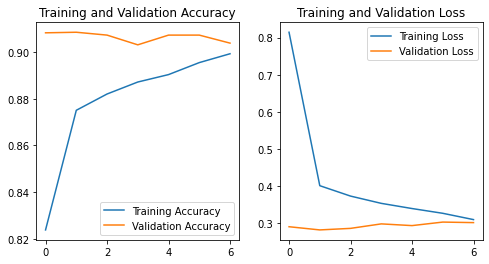

Wall time: 42.5 s


In [62]:
%%time
model_InceptionResNetV2,image_gen_train_InceptionResNetV2,image_gen_test_InceptionResNetV2 = process_models(model_base_InceptionResNetV2, predictions_InceptionResNetV2 , preprocess_input_InceptionResNetV2 )

img_shape = (299,299,3)
try : 
    transfert_InceptionResNetV2 , score_transfert_InceptionResNetV2 = fit_model(model_InceptionResNetV2, 'transfert_InceptionResNetV2', img_shape,
                                                    image_gen_train_InceptionResNetV2 , image_gen_test_InceptionResNetV2)
except:
    transfert_InceptionResNetV2 = load_model(models_path+'transfert_InceptionResNetV2')
    score_transfert_InceptionResNetV2 = load(results_path+'score_transfert_InceptionResNetV2.joblib')
    transfert_InceptionResNetV2.summary()
    plot_metrics(score_transfert_InceptionResNetV2)

<p STYLE="padding-left:1em ; color:blue;text-align: justify;"><b> Nous observons de bonnes prédictions avec ce modèle. Nous allons re-entrainer ce modèle avec tous ses paramètres libres pour un ajustement fin. 

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_100 (Conv2D)            (None, 149, 149, 32  864         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_104 (Batch  (None, 149, 149, 32  96         ['conv2d_100[0][0]']             
 Normalization)                 )                                                           

 conv2d_111 (Conv2D)            (None, 35, 35, 64)   12288       ['average_pooling2d_9[0][0]']    
                                                                                                  
 batch_normalization_109 (Batch  (None, 35, 35, 96)  288         ['conv2d_105[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_111 (Batch  (None, 35, 35, 64)  192         ['conv2d_107[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_114 (Batch  (None, 35, 35, 96)  288         ['conv2d_110[0][0]']             
 Normalization)                                                                                   
          

 Normalization)                                                                                   
                                                                                                  
 activation_115 (Activation)    (None, 35, 35, 32)   0           ['batch_normalization_125[0][0]']
                                                                                                  
 conv2d_119 (Conv2D)            (None, 35, 35, 32)   10240       ['block35_1_ac[0][0]']           
                                                                                                  
 conv2d_122 (Conv2D)            (None, 35, 35, 48)   13824       ['activation_115[0][0]']         
                                                                                                  
 batch_normalization_123 (Batch  (None, 35, 35, 32)  96          ['conv2d_119[0][0]']             
 Normalization)                                                                                   
          

 batch_normalization_133 (Batch  (None, 35, 35, 64)  192         ['conv2d_129[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_118 (Activation)    (None, 35, 35, 32)   0           ['batch_normalization_128[0][0]']
                                                                                                  
 activation_120 (Activation)    (None, 35, 35, 32)   0           ['batch_normalization_130[0][0]']
                                                                                                  
 activation_123 (Activation)    (None, 35, 35, 64)   0           ['batch_normalization_133[0][0]']
                                                                                                  
 block35_3_mixed (Concatenate)  (None, 35, 35, 128)  0           ['activation_118[0][0]',         
          

                                                                                                  
 batch_normalization_141 (Batch  (None, 35, 35, 32)  96          ['conv2d_137[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_144 (Batch  (None, 35, 35, 48)  144         ['conv2d_140[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_131 (Activation)    (None, 35, 35, 32)   0           ['batch_normalization_141[0][0]']
                                                                                                  
 activation_134 (Activation)    (None, 35, 35, 48)   0           ['batch_normalization_144[0][0]']
          

 activation_141 (Activation)    (None, 35, 35, 64)   0           ['batch_normalization_151[0][0]']
                                                                                                  
 block35_6_mixed (Concatenate)  (None, 35, 35, 128)  0           ['activation_136[0][0]',         
                                                                  'activation_138[0][0]',         
                                                                  'activation_141[0][0]']         
                                                                                                  
 block35_6_conv (Conv2D)        (None, 35, 35, 320)  41280       ['block35_6_mixed[0][0]']        
                                                                                                  
 block35_6 (Lambda)             (None, 35, 35, 320)  0           ['block35_5_ac[0][0]',           
                                                                  'block35_6_conv[0][0]']         
          

 activation_149 (Activation)    (None, 35, 35, 32)   0           ['batch_normalization_159[0][0]']
                                                                                                  
 activation_152 (Activation)    (None, 35, 35, 48)   0           ['batch_normalization_162[0][0]']
                                                                                                  
 conv2d_154 (Conv2D)            (None, 35, 35, 32)   10240       ['block35_7_ac[0][0]']           
                                                                                                  
 conv2d_156 (Conv2D)            (None, 35, 35, 32)   9216        ['activation_149[0][0]']         
                                                                                                  
 conv2d_159 (Conv2D)            (None, 35, 35, 64)   27648       ['activation_152[0][0]']         
                                                                                                  
 batch_nor

                                                                                                  
 block35_9 (Lambda)             (None, 35, 35, 320)  0           ['block35_8_ac[0][0]',           
                                                                  'block35_9_conv[0][0]']         
                                                                                                  
 block35_9_ac (Activation)      (None, 35, 35, 320)  0           ['block35_9[0][0]']              
                                                                                                  
 conv2d_169 (Conv2D)            (None, 35, 35, 32)   10240       ['block35_9_ac[0][0]']           
                                                                                                  
 batch_normalization_173 (Batch  (None, 35, 35, 32)  96          ['conv2d_169[0][0]']             
 Normalization)                                                                                   
          

 activation_166 (Activation)    (None, 17, 17, 384)  0           ['batch_normalization_176[0][0]']
                                                                                                  
 activation_169 (Activation)    (None, 17, 17, 384)  0           ['batch_normalization_179[0][0]']
                                                                                                  
 max_pooling2d_12 (MaxPooling2D  (None, 17, 17, 320)  0          ['block35_10_ac[0][0]']          
 )                                                                                                
                                                                                                  
 mixed_6a (Concatenate)         (None, 17, 17, 1088  0           ['activation_166[0][0]',         
                                )                                 'activation_169[0][0]',         
                                                                  'max_pooling2d_12[0][0]']       
          

                                )                                                                 
                                                                                                  
 block17_2 (Lambda)             (None, 17, 17, 1088  0           ['block17_1_ac[0][0]',           
                                )                                 'block17_2_conv[0][0]']         
                                                                                                  
 block17_2_ac (Activation)      (None, 17, 17, 1088  0           ['block17_2[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_185 (Conv2D)            (None, 17, 17, 128)  139264      ['block17_2_ac[0][0]']           
                                                                                                  
 batch_nor

                                )                                 'block17_4_conv[0][0]']         
                                                                                                  
 block17_4_ac (Activation)      (None, 17, 17, 1088  0           ['block17_4[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_193 (Conv2D)            (None, 17, 17, 128)  139264      ['block17_4_ac[0][0]']           
                                                                                                  
 batch_normalization_197 (Batch  (None, 17, 17, 128)  384        ['conv2d_193[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

                                )                                                                 
                                                                                                  
 conv2d_201 (Conv2D)            (None, 17, 17, 128)  139264      ['block17_6_ac[0][0]']           
                                                                                                  
 batch_normalization_205 (Batch  (None, 17, 17, 128)  384        ['conv2d_201[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_195 (Activation)    (None, 17, 17, 128)  0           ['batch_normalization_205[0][0]']
                                                                                                  
 conv2d_202 (Conv2D)            (None, 17, 17, 160)  143360      ['activation_195[0][0]']         
          

                                                                                                  
 batch_normalization_213 (Batch  (None, 17, 17, 128)  384        ['conv2d_209[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_203 (Activation)    (None, 17, 17, 128)  0           ['batch_normalization_213[0][0]']
                                                                                                  
 conv2d_210 (Conv2D)            (None, 17, 17, 160)  143360      ['activation_203[0][0]']         
                                                                                                  
 batch_normalization_214 (Batch  (None, 17, 17, 160)  480        ['conv2d_210[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 activation_211 (Activation)    (None, 17, 17, 128)  0           ['batch_normalization_221[0][0]']
                                                                                                  
 conv2d_218 (Conv2D)            (None, 17, 17, 160)  143360      ['activation_211[0][0]']         
                                                                                                  
 batch_normalization_222 (Batch  (None, 17, 17, 160)  480        ['conv2d_218[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_212 (Activation)    (None, 17, 17, 160)  0           ['batch_normalization_222[0][0]']
                                                                                                  
 conv2d_21

 conv2d_226 (Conv2D)            (None, 17, 17, 160)  143360      ['activation_219[0][0]']         
                                                                                                  
 batch_normalization_230 (Batch  (None, 17, 17, 160)  480        ['conv2d_226[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_220 (Activation)    (None, 17, 17, 160)  0           ['batch_normalization_230[0][0]']
                                                                                                  
 conv2d_224 (Conv2D)            (None, 17, 17, 192)  208896      ['block17_12_ac[0][0]']          
                                                                                                  
 conv2d_227 (Conv2D)            (None, 17, 17, 192)  215040      ['activation_220[0][0]']         
          

 Normalization)                                                                                   
                                                                                                  
 activation_228 (Activation)    (None, 17, 17, 160)  0           ['batch_normalization_238[0][0]']
                                                                                                  
 conv2d_232 (Conv2D)            (None, 17, 17, 192)  208896      ['block17_14_ac[0][0]']          
                                                                                                  
 conv2d_235 (Conv2D)            (None, 17, 17, 192)  215040      ['activation_228[0][0]']         
                                                                                                  
 batch_normalization_236 (Batch  (None, 17, 17, 192)  576        ['conv2d_232[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 conv2d_240 (Conv2D)            (None, 17, 17, 192)  208896      ['block17_16_ac[0][0]']          
                                                                                                  
 conv2d_243 (Conv2D)            (None, 17, 17, 192)  215040      ['activation_236[0][0]']         
                                                                                                  
 batch_normalization_244 (Batch  (None, 17, 17, 192)  576        ['conv2d_240[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_247 (Batch  (None, 17, 17, 192)  576        ['conv2d_243[0][0]']             
 Normalization)                                                                                   
          

 conv2d_251 (Conv2D)            (None, 17, 17, 192)  215040      ['activation_244[0][0]']         
                                                                                                  
 batch_normalization_252 (Batch  (None, 17, 17, 192)  576        ['conv2d_248[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_255 (Batch  (None, 17, 17, 192)  576        ['conv2d_251[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_242 (Activation)    (None, 17, 17, 192)  0           ['batch_normalization_252[0][0]']
                                                                                                  
 activatio

 batch_normalization_265 (Batch  (None, 17, 17, 288)  864        ['conv2d_261[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_250 (Activation)    (None, 17, 17, 256)  0           ['batch_normalization_260[0][0]']
                                                                                                  
 activation_252 (Activation)    (None, 17, 17, 256)  0           ['batch_normalization_262[0][0]']
                                                                                                  
 activation_255 (Activation)    (None, 17, 17, 288)  0           ['batch_normalization_265[0][0]']
                                                                                                  
 conv2d_257 (Conv2D)            (None, 8, 8, 384)    884736      ['activation_250[0][0]']         
          

 conv2d_269 (Conv2D)            (None, 8, 8, 224)    129024      ['activation_262[0][0]']         
                                                                                                  
 batch_normalization_273 (Batch  (None, 8, 8, 224)   672         ['conv2d_269[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_263 (Activation)    (None, 8, 8, 224)    0           ['batch_normalization_273[0][0]']
                                                                                                  
 conv2d_267 (Conv2D)            (None, 8, 8, 192)    399360      ['block8_1_ac[0][0]']            
                                                                                                  
 conv2d_270 (Conv2D)            (None, 8, 8, 256)    172032      ['activation_263[0][0]']         
          

 conv2d_275 (Conv2D)            (None, 8, 8, 192)    399360      ['block8_3_ac[0][0]']            
                                                                                                  
 conv2d_278 (Conv2D)            (None, 8, 8, 256)    172032      ['activation_271[0][0]']         
                                                                                                  
 batch_normalization_279 (Batch  (None, 8, 8, 192)   576         ['conv2d_275[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_282 (Batch  (None, 8, 8, 256)   768         ['conv2d_278[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

 batch_normalization_290 (Batch  (None, 8, 8, 256)   768         ['conv2d_286[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_277 (Activation)    (None, 8, 8, 192)    0           ['batch_normalization_287[0][0]']
                                                                                                  
 activation_280 (Activation)    (None, 8, 8, 256)    0           ['batch_normalization_290[0][0]']
                                                                                                  
 block8_6_mixed (Concatenate)   (None, 8, 8, 448)    0           ['activation_277[0][0]',         
                                                                  'activation_280[0][0]']         
                                                                                                  
 block8_6_

 block8_8_mixed (Concatenate)   (None, 8, 8, 448)    0           ['activation_285[0][0]',         
                                                                  'activation_288[0][0]']         
                                                                                                  
 block8_8_conv (Conv2D)         (None, 8, 8, 2080)   933920      ['block8_8_mixed[0][0]']         
                                                                                                  
 block8_8 (Lambda)              (None, 8, 8, 2080)   0           ['block8_7_ac[0][0]',            
                                                                  'block8_8_conv[0][0]']          
                                                                                                  
 block8_8_ac (Activation)       (None, 8, 8, 2080)   0           ['block8_8[0][0]']               
                                                                                                  
 conv2d_29

                                                                                                  
 conv_7b (Conv2D)               (None, 8, 8, 1536)   3194880     ['block8_10[0][0]']              
                                                                                                  
 conv_7b_bn (BatchNormalization  (None, 8, 8, 1536)  4608        ['conv_7b[0][0]']                
 )                                                                                                
                                                                                                  
 conv_7b_ac (Activation)        (None, 8, 8, 1536)   0           ['conv_7b_bn[0][0]']             
                                                                                                  
 global_average_pooling2d_1 (Gl  (None, 1536)        0           ['conv_7b_ac[0][0]']             
 obalAveragePooling2D)                                                                            
          

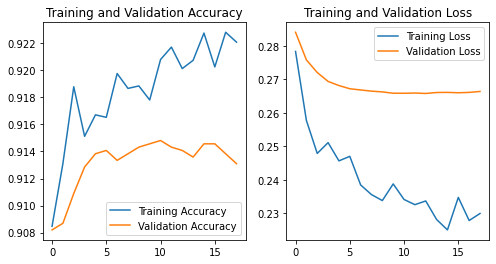

Wall time: 40.6 s


In [63]:
%%time
model_base_InceptionResNetV2.trainable = True
transfert_InceptionResNetV2.compile(optimizer=keras.optimizers.Adam(1e-5),# Low learning rate
                                    loss='categorical_crossentropy',metrics=['accuracy'])

img_shape = (299,299,3)
try : 
    transfert_InceptionResNetV2_ajust , score_transfert_InceptionResNetV2_ajust = fit_model(transfert_InceptionResNetV2, 'transfert_InceptionResNetV2_ajust',  img_shape,
                                                                                        image_gen_train_InceptionResNetV2 , image_gen_test_InceptionResNetV2)
except:
    transfert_InceptionResNetV2_ajust = load_model(models_path+'transfert_InceptionResNetV2_ajust')
    score_transfert_InceptionResNetV2_ajust = load(results_path+'score_transfert_InceptionResNetV2_ajust.joblib')
    transfert_InceptionResNetV2_ajust.summary()
    plot_metrics(score_transfert_InceptionResNetV2_ajust)

<p STYLE="padding-left:1em ; color:blue;text-align: justify;"><b> Nous observons une amélioration des prédictions.

In [64]:
model_base_InceptionResNetV2_02 = InceptionResNetV2(weights="imagenet", include_top=False,input_tensor=new_imput,input_shape=img_shape )
model_base_InceptionResNetV2_02.trainable = False
model_base_InceptionResNetV2_02.summary()

x_InceptionResNetV2_02 = GlobalAveragePooling2D()(model_base_InceptionResNetV2_02.output)
x_InceptionResNetV2_02 = keras.layers.Dropout(0.3)(x_InceptionResNetV2_02)
predictions_InceptionResNetV2_02 = Dense(num_class, activation='softmax')(x_InceptionResNetV2_02)

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_203 (Conv2D)            (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_203 (Batch  (None, 149, 149, 32  96         ['conv2d_203[0][0]']             
 Normalization)                 )                                               

 batch_normalization_208 (Batch  (None, 35, 35, 96)  288         ['conv2d_208[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_210 (Batch  (None, 35, 35, 64)  192         ['conv2d_210[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_213 (Batch  (None, 35, 35, 96)  288         ['conv2d_213[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_214 (Batch  (None, 35, 35, 64)  192         ['conv2d_214[0][0]']             
 Normaliza

 activation_224 (Activation)    (None, 35, 35, 32)   0           ['batch_normalization_224[0][0]']
                                                                                                  
 conv2d_222 (Conv2D)            (None, 35, 35, 32)   10240       ['block35_1_ac[0][0]']           
                                                                                                  
 conv2d_225 (Conv2D)            (None, 35, 35, 48)   13824       ['activation_224[0][0]']         
                                                                                                  
 batch_normalization_222 (Batch  (None, 35, 35, 32)  96          ['conv2d_222[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_225 (Batch  (None, 35, 35, 48)  144         ['conv2d_225[0][0]']             
 Normaliza

                                                                                                  
 activation_227 (Activation)    (None, 35, 35, 32)   0           ['batch_normalization_227[0][0]']
                                                                                                  
 activation_229 (Activation)    (None, 35, 35, 32)   0           ['batch_normalization_229[0][0]']
                                                                                                  
 activation_232 (Activation)    (None, 35, 35, 64)   0           ['batch_normalization_232[0][0]']
                                                                                                  
 block35_3_mixed (Concatenate)  (None, 35, 35, 128)  0           ['activation_227[0][0]',         
                                                                  'activation_229[0][0]',         
                                                                  'activation_232[0][0]']         
          

 Normalization)                                                                                   
                                                                                                  
 batch_normalization_243 (Batch  (None, 35, 35, 48)  144         ['conv2d_243[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_240 (Activation)    (None, 35, 35, 32)   0           ['batch_normalization_240[0][0]']
                                                                                                  
 activation_243 (Activation)    (None, 35, 35, 48)   0           ['batch_normalization_243[0][0]']
                                                                                                  
 conv2d_239 (Conv2D)            (None, 35, 35, 32)   10240       ['block35_4_ac[0][0]']           
          

 block35_6_mixed (Concatenate)  (None, 35, 35, 128)  0           ['activation_245[0][0]',         
                                                                  'activation_247[0][0]',         
                                                                  'activation_250[0][0]']         
                                                                                                  
 block35_6_conv (Conv2D)        (None, 35, 35, 320)  41280       ['block35_6_mixed[0][0]']        
                                                                                                  
 block35_6 (Lambda)             (None, 35, 35, 320)  0           ['block35_5_ac[0][0]',           
                                                                  'block35_6_conv[0][0]']         
                                                                                                  
 block35_6_ac (Activation)      (None, 35, 35, 320)  0           ['block35_6[0][0]']              
          

 activation_261 (Activation)    (None, 35, 35, 48)   0           ['batch_normalization_261[0][0]']
                                                                                                  
 conv2d_257 (Conv2D)            (None, 35, 35, 32)   10240       ['block35_7_ac[0][0]']           
                                                                                                  
 conv2d_259 (Conv2D)            (None, 35, 35, 32)   9216        ['activation_258[0][0]']         
                                                                                                  
 conv2d_262 (Conv2D)            (None, 35, 35, 64)   27648       ['activation_261[0][0]']         
                                                                                                  
 batch_normalization_257 (Batch  (None, 35, 35, 32)  96          ['conv2d_257[0][0]']             
 Normalization)                                                                                   
          

                                                                  'block35_9_conv[0][0]']         
                                                                                                  
 block35_9_ac (Activation)      (None, 35, 35, 320)  0           ['block35_9[0][0]']              
                                                                                                  
 conv2d_272 (Conv2D)            (None, 35, 35, 32)   10240       ['block35_9_ac[0][0]']           
                                                                                                  
 batch_normalization_272 (Batch  (None, 35, 35, 32)  96          ['conv2d_272[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_272 (Activation)    (None, 35, 35, 32)   0           ['batch_normalization_272[0][0]']
          

 activation_278 (Activation)    (None, 17, 17, 384)  0           ['batch_normalization_278[0][0]']
                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 17, 17, 320)  0          ['block35_10_ac[0][0]']          
                                                                                                  
 mixed_6a (Concatenate)         (None, 17, 17, 1088  0           ['activation_275[0][0]',         
                                )                                 'activation_278[0][0]',         
                                                                  'max_pooling2d_6[0][0]']        
                                                                                                  
 conv2d_280 (Conv2D)            (None, 17, 17, 128)  139264      ['mixed_6a[0][0]']               
                                                                                                  
 batch_nor

                                )                                 'block17_2_conv[0][0]']         
                                                                                                  
 block17_2_ac (Activation)      (None, 17, 17, 1088  0           ['block17_2[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_288 (Conv2D)            (None, 17, 17, 128)  139264      ['block17_2_ac[0][0]']           
                                                                                                  
 batch_normalization_288 (Batch  (None, 17, 17, 128)  384        ['conv2d_288[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

                                )                                                                 
                                                                                                  
 conv2d_296 (Conv2D)            (None, 17, 17, 128)  139264      ['block17_4_ac[0][0]']           
                                                                                                  
 batch_normalization_296 (Batch  (None, 17, 17, 128)  384        ['conv2d_296[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_296 (Activation)    (None, 17, 17, 128)  0           ['batch_normalization_296[0][0]']
                                                                                                  
 conv2d_297 (Conv2D)            (None, 17, 17, 160)  143360      ['activation_296[0][0]']         
          

                                                                                                  
 batch_normalization_304 (Batch  (None, 17, 17, 128)  384        ['conv2d_304[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_304 (Activation)    (None, 17, 17, 128)  0           ['batch_normalization_304[0][0]']
                                                                                                  
 conv2d_305 (Conv2D)            (None, 17, 17, 160)  143360      ['activation_304[0][0]']         
                                                                                                  
 batch_normalization_305 (Batch  (None, 17, 17, 160)  480        ['conv2d_305[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 activation_312 (Activation)    (None, 17, 17, 128)  0           ['batch_normalization_312[0][0]']
                                                                                                  
 conv2d_313 (Conv2D)            (None, 17, 17, 160)  143360      ['activation_312[0][0]']         
                                                                                                  
 batch_normalization_313 (Batch  (None, 17, 17, 160)  480        ['conv2d_313[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_313 (Activation)    (None, 17, 17, 160)  0           ['batch_normalization_313[0][0]']
                                                                                                  
 conv2d_31

 conv2d_321 (Conv2D)            (None, 17, 17, 160)  143360      ['activation_320[0][0]']         
                                                                                                  
 batch_normalization_321 (Batch  (None, 17, 17, 160)  480        ['conv2d_321[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_321 (Activation)    (None, 17, 17, 160)  0           ['batch_normalization_321[0][0]']
                                                                                                  
 conv2d_319 (Conv2D)            (None, 17, 17, 192)  208896      ['block17_10_ac[0][0]']          
                                                                                                  
 conv2d_322 (Conv2D)            (None, 17, 17, 192)  215040      ['activation_321[0][0]']         
          

 Normalization)                                                                                   
                                                                                                  
 activation_329 (Activation)    (None, 17, 17, 160)  0           ['batch_normalization_329[0][0]']
                                                                                                  
 conv2d_327 (Conv2D)            (None, 17, 17, 192)  208896      ['block17_12_ac[0][0]']          
                                                                                                  
 conv2d_330 (Conv2D)            (None, 17, 17, 192)  215040      ['activation_329[0][0]']         
                                                                                                  
 batch_normalization_327 (Batch  (None, 17, 17, 192)  576        ['conv2d_327[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 conv2d_335 (Conv2D)            (None, 17, 17, 192)  208896      ['block17_14_ac[0][0]']          
                                                                                                  
 conv2d_338 (Conv2D)            (None, 17, 17, 192)  215040      ['activation_337[0][0]']         
                                                                                                  
 batch_normalization_335 (Batch  (None, 17, 17, 192)  576        ['conv2d_335[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_338 (Batch  (None, 17, 17, 192)  576        ['conv2d_338[0][0]']             
 Normalization)                                                                                   
          

 conv2d_346 (Conv2D)            (None, 17, 17, 192)  215040      ['activation_345[0][0]']         
                                                                                                  
 batch_normalization_343 (Batch  (None, 17, 17, 192)  576        ['conv2d_343[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_346 (Batch  (None, 17, 17, 192)  576        ['conv2d_346[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_343 (Activation)    (None, 17, 17, 192)  0           ['batch_normalization_343[0][0]']
                                                                                                  
 activatio

 Normalization)                                                                                   
                                                                                                  
 batch_normalization_354 (Batch  (None, 17, 17, 192)  576        ['conv2d_354[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_351 (Activation)    (None, 17, 17, 192)  0           ['batch_normalization_351[0][0]']
                                                                                                  
 activation_354 (Activation)    (None, 17, 17, 192)  0           ['batch_normalization_354[0][0]']
                                                                                                  
 block17_19_mixed (Concatenate)  (None, 17, 17, 384)  0          ['activation_351[0][0]',         
          

 activation_359 (Activation)    (None, 17, 17, 256)  0           ['batch_normalization_359[0][0]']
                                                                                                  
 activation_361 (Activation)    (None, 17, 17, 256)  0           ['batch_normalization_361[0][0]']
                                                                                                  
 activation_364 (Activation)    (None, 17, 17, 288)  0           ['batch_normalization_364[0][0]']
                                                                                                  
 conv2d_360 (Conv2D)            (None, 8, 8, 384)    884736      ['activation_359[0][0]']         
                                                                                                  
 conv2d_362 (Conv2D)            (None, 8, 8, 288)    663552      ['activation_361[0][0]']         
                                                                                                  
 conv2d_36

                                                                                                  
 activation_372 (Activation)    (None, 8, 8, 224)    0           ['batch_normalization_372[0][0]']
                                                                                                  
 conv2d_370 (Conv2D)            (None, 8, 8, 192)    399360      ['block8_1_ac[0][0]']            
                                                                                                  
 conv2d_373 (Conv2D)            (None, 8, 8, 256)    172032      ['activation_372[0][0]']         
                                                                                                  
 batch_normalization_370 (Batch  (None, 8, 8, 192)   576         ['conv2d_370[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_nor

 batch_normalization_378 (Batch  (None, 8, 8, 192)   576         ['conv2d_378[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_381 (Batch  (None, 8, 8, 256)   768         ['conv2d_381[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_378 (Activation)    (None, 8, 8, 192)    0           ['batch_normalization_378[0][0]']
                                                                                                  
 activation_381 (Activation)    (None, 8, 8, 256)    0           ['batch_normalization_381[0][0]']
                                                                                                  
 block8_4_

                                                                                                  
 activation_389 (Activation)    (None, 8, 8, 256)    0           ['batch_normalization_389[0][0]']
                                                                                                  
 block8_6_mixed (Concatenate)   (None, 8, 8, 448)    0           ['activation_386[0][0]',         
                                                                  'activation_389[0][0]']         
                                                                                                  
 block8_6_conv (Conv2D)         (None, 8, 8, 2080)   933920      ['block8_6_mixed[0][0]']         
                                                                                                  
 block8_6 (Lambda)              (None, 8, 8, 2080)   0           ['block8_5_ac[0][0]',            
                                                                  'block8_6_conv[0][0]']          
          

                                                                                                  
 block8_8 (Lambda)              (None, 8, 8, 2080)   0           ['block8_7_ac[0][0]',            
                                                                  'block8_8_conv[0][0]']          
                                                                                                  
 block8_8_ac (Activation)       (None, 8, 8, 2080)   0           ['block8_8[0][0]']               
                                                                                                  
 conv2d_399 (Conv2D)            (None, 8, 8, 192)    399360      ['block8_8_ac[0][0]']            
                                                                                                  
 batch_normalization_399 (Batch  (None, 8, 8, 192)   576         ['conv2d_399[0][0]']             
 Normalization)                                                                                   
          

 )                                                                                                
                                                                                                  
 conv_7b_ac (Activation)        (None, 8, 8, 1536)   0           ['conv_7b_bn[0][0]']             
                                                                                                  
Total params: 54,336,736
Trainable params: 0
Non-trainable params: 54,336,736
__________________________________________________________________________________________________


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_303 (Conv2D)            (None, 149, 149, 32  864         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_307 (Batch  (None, 149, 149, 32  96         ['conv2d_303[0][0]']             
 Normalization)                 )                                                           

 conv2d_314 (Conv2D)            (None, 35, 35, 64)   12288       ['average_pooling2d_10[0][0]']   
                                                                                                  
 batch_normalization_312 (Batch  (None, 35, 35, 96)  288         ['conv2d_308[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_314 (Batch  (None, 35, 35, 64)  192         ['conv2d_310[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_317 (Batch  (None, 35, 35, 96)  288         ['conv2d_313[0][0]']             
 Normalization)                                                                                   
          

 Normalization)                                                                                   
                                                                                                  
 activation_318 (Activation)    (None, 35, 35, 32)   0           ['batch_normalization_328[0][0]']
                                                                                                  
 conv2d_322 (Conv2D)            (None, 35, 35, 32)   10240       ['block35_1_ac[0][0]']           
                                                                                                  
 conv2d_325 (Conv2D)            (None, 35, 35, 48)   13824       ['activation_318[0][0]']         
                                                                                                  
 batch_normalization_326 (Batch  (None, 35, 35, 32)  96          ['conv2d_322[0][0]']             
 Normalization)                                                                                   
          

 batch_normalization_336 (Batch  (None, 35, 35, 64)  192         ['conv2d_332[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_321 (Activation)    (None, 35, 35, 32)   0           ['batch_normalization_331[0][0]']
                                                                                                  
 activation_323 (Activation)    (None, 35, 35, 32)   0           ['batch_normalization_333[0][0]']
                                                                                                  
 activation_326 (Activation)    (None, 35, 35, 64)   0           ['batch_normalization_336[0][0]']
                                                                                                  
 block35_3_mixed (Concatenate)  (None, 35, 35, 128)  0           ['activation_321[0][0]',         
          

                                                                                                  
 batch_normalization_344 (Batch  (None, 35, 35, 32)  96          ['conv2d_340[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_347 (Batch  (None, 35, 35, 48)  144         ['conv2d_343[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_334 (Activation)    (None, 35, 35, 32)   0           ['batch_normalization_344[0][0]']
                                                                                                  
 activation_337 (Activation)    (None, 35, 35, 48)   0           ['batch_normalization_347[0][0]']
          

 activation_344 (Activation)    (None, 35, 35, 64)   0           ['batch_normalization_354[0][0]']
                                                                                                  
 block35_6_mixed (Concatenate)  (None, 35, 35, 128)  0           ['activation_339[0][0]',         
                                                                  'activation_341[0][0]',         
                                                                  'activation_344[0][0]']         
                                                                                                  
 block35_6_conv (Conv2D)        (None, 35, 35, 320)  41280       ['block35_6_mixed[0][0]']        
                                                                                                  
 block35_6 (Lambda)             (None, 35, 35, 320)  0           ['block35_5_ac[0][0]',           
                                                                  'block35_6_conv[0][0]']         
          

 activation_352 (Activation)    (None, 35, 35, 32)   0           ['batch_normalization_362[0][0]']
                                                                                                  
 activation_355 (Activation)    (None, 35, 35, 48)   0           ['batch_normalization_365[0][0]']
                                                                                                  
 conv2d_357 (Conv2D)            (None, 35, 35, 32)   10240       ['block35_7_ac[0][0]']           
                                                                                                  
 conv2d_359 (Conv2D)            (None, 35, 35, 32)   9216        ['activation_352[0][0]']         
                                                                                                  
 conv2d_362 (Conv2D)            (None, 35, 35, 64)   27648       ['activation_355[0][0]']         
                                                                                                  
 batch_nor

                                                                                                  
 block35_9 (Lambda)             (None, 35, 35, 320)  0           ['block35_8_ac[0][0]',           
                                                                  'block35_9_conv[0][0]']         
                                                                                                  
 block35_9_ac (Activation)      (None, 35, 35, 320)  0           ['block35_9[0][0]']              
                                                                                                  
 conv2d_372 (Conv2D)            (None, 35, 35, 32)   10240       ['block35_9_ac[0][0]']           
                                                                                                  
 batch_normalization_376 (Batch  (None, 35, 35, 32)  96          ['conv2d_372[0][0]']             
 Normalization)                                                                                   
          

 activation_369 (Activation)    (None, 17, 17, 384)  0           ['batch_normalization_379[0][0]']
                                                                                                  
 activation_372 (Activation)    (None, 17, 17, 384)  0           ['batch_normalization_382[0][0]']
                                                                                                  
 max_pooling2d_16 (MaxPooling2D  (None, 17, 17, 320)  0          ['block35_10_ac[0][0]']          
 )                                                                                                
                                                                                                  
 mixed_6a (Concatenate)         (None, 17, 17, 1088  0           ['activation_369[0][0]',         
                                )                                 'activation_372[0][0]',         
                                                                  'max_pooling2d_16[0][0]']       
          

                                )                                                                 
                                                                                                  
 block17_2 (Lambda)             (None, 17, 17, 1088  0           ['block17_1_ac[0][0]',           
                                )                                 'block17_2_conv[0][0]']         
                                                                                                  
 block17_2_ac (Activation)      (None, 17, 17, 1088  0           ['block17_2[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_388 (Conv2D)            (None, 17, 17, 128)  139264      ['block17_2_ac[0][0]']           
                                                                                                  
 batch_nor

                                )                                 'block17_4_conv[0][0]']         
                                                                                                  
 block17_4_ac (Activation)      (None, 17, 17, 1088  0           ['block17_4[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_396 (Conv2D)            (None, 17, 17, 128)  139264      ['block17_4_ac[0][0]']           
                                                                                                  
 batch_normalization_400 (Batch  (None, 17, 17, 128)  384        ['conv2d_396[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

                                )                                                                 
                                                                                                  
 conv2d_404 (Conv2D)            (None, 17, 17, 128)  139264      ['block17_6_ac[0][0]']           
                                                                                                  
 batch_normalization_408 (Batch  (None, 17, 17, 128)  384        ['conv2d_404[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_398 (Activation)    (None, 17, 17, 128)  0           ['batch_normalization_408[0][0]']
                                                                                                  
 conv2d_405 (Conv2D)            (None, 17, 17, 160)  143360      ['activation_398[0][0]']         
          

                                                                                                  
 batch_normalization_416 (Batch  (None, 17, 17, 128)  384        ['conv2d_412[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_406 (Activation)    (None, 17, 17, 128)  0           ['batch_normalization_416[0][0]']
                                                                                                  
 conv2d_413 (Conv2D)            (None, 17, 17, 160)  143360      ['activation_406[0][0]']         
                                                                                                  
 batch_normalization_417 (Batch  (None, 17, 17, 160)  480        ['conv2d_413[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 activation_414 (Activation)    (None, 17, 17, 128)  0           ['batch_normalization_424[0][0]']
                                                                                                  
 conv2d_421 (Conv2D)            (None, 17, 17, 160)  143360      ['activation_414[0][0]']         
                                                                                                  
 batch_normalization_425 (Batch  (None, 17, 17, 160)  480        ['conv2d_421[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_415 (Activation)    (None, 17, 17, 160)  0           ['batch_normalization_425[0][0]']
                                                                                                  
 conv2d_41

 conv2d_429 (Conv2D)            (None, 17, 17, 160)  143360      ['activation_422[0][0]']         
                                                                                                  
 batch_normalization_433 (Batch  (None, 17, 17, 160)  480        ['conv2d_429[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_423 (Activation)    (None, 17, 17, 160)  0           ['batch_normalization_433[0][0]']
                                                                                                  
 conv2d_427 (Conv2D)            (None, 17, 17, 192)  208896      ['block17_12_ac[0][0]']          
                                                                                                  
 conv2d_430 (Conv2D)            (None, 17, 17, 192)  215040      ['activation_423[0][0]']         
          

 Normalization)                                                                                   
                                                                                                  
 activation_431 (Activation)    (None, 17, 17, 160)  0           ['batch_normalization_441[0][0]']
                                                                                                  
 conv2d_435 (Conv2D)            (None, 17, 17, 192)  208896      ['block17_14_ac[0][0]']          
                                                                                                  
 conv2d_438 (Conv2D)            (None, 17, 17, 192)  215040      ['activation_431[0][0]']         
                                                                                                  
 batch_normalization_439 (Batch  (None, 17, 17, 192)  576        ['conv2d_435[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 conv2d_443 (Conv2D)            (None, 17, 17, 192)  208896      ['block17_16_ac[0][0]']          
                                                                                                  
 conv2d_446 (Conv2D)            (None, 17, 17, 192)  215040      ['activation_439[0][0]']         
                                                                                                  
 batch_normalization_447 (Batch  (None, 17, 17, 192)  576        ['conv2d_443[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_450 (Batch  (None, 17, 17, 192)  576        ['conv2d_446[0][0]']             
 Normalization)                                                                                   
          

 conv2d_454 (Conv2D)            (None, 17, 17, 192)  215040      ['activation_447[0][0]']         
                                                                                                  
 batch_normalization_455 (Batch  (None, 17, 17, 192)  576        ['conv2d_451[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_458 (Batch  (None, 17, 17, 192)  576        ['conv2d_454[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_445 (Activation)    (None, 17, 17, 192)  0           ['batch_normalization_455[0][0]']
                                                                                                  
 activatio

 batch_normalization_468 (Batch  (None, 17, 17, 288)  864        ['conv2d_464[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_453 (Activation)    (None, 17, 17, 256)  0           ['batch_normalization_463[0][0]']
                                                                                                  
 activation_455 (Activation)    (None, 17, 17, 256)  0           ['batch_normalization_465[0][0]']
                                                                                                  
 activation_458 (Activation)    (None, 17, 17, 288)  0           ['batch_normalization_468[0][0]']
                                                                                                  
 conv2d_460 (Conv2D)            (None, 8, 8, 384)    884736      ['activation_453[0][0]']         
          

 conv2d_472 (Conv2D)            (None, 8, 8, 224)    129024      ['activation_465[0][0]']         
                                                                                                  
 batch_normalization_476 (Batch  (None, 8, 8, 224)   672         ['conv2d_472[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_466 (Activation)    (None, 8, 8, 224)    0           ['batch_normalization_476[0][0]']
                                                                                                  
 conv2d_470 (Conv2D)            (None, 8, 8, 192)    399360      ['block8_1_ac[0][0]']            
                                                                                                  
 conv2d_473 (Conv2D)            (None, 8, 8, 256)    172032      ['activation_466[0][0]']         
          

 conv2d_478 (Conv2D)            (None, 8, 8, 192)    399360      ['block8_3_ac[0][0]']            
                                                                                                  
 conv2d_481 (Conv2D)            (None, 8, 8, 256)    172032      ['activation_474[0][0]']         
                                                                                                  
 batch_normalization_482 (Batch  (None, 8, 8, 192)   576         ['conv2d_478[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_485 (Batch  (None, 8, 8, 256)   768         ['conv2d_481[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

 batch_normalization_493 (Batch  (None, 8, 8, 256)   768         ['conv2d_489[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_480 (Activation)    (None, 8, 8, 192)    0           ['batch_normalization_490[0][0]']
                                                                                                  
 activation_483 (Activation)    (None, 8, 8, 256)    0           ['batch_normalization_493[0][0]']
                                                                                                  
 block8_6_mixed (Concatenate)   (None, 8, 8, 448)    0           ['activation_480[0][0]',         
                                                                  'activation_483[0][0]']         
                                                                                                  
 block8_6_

 block8_8_mixed (Concatenate)   (None, 8, 8, 448)    0           ['activation_488[0][0]',         
                                                                  'activation_491[0][0]']         
                                                                                                  
 block8_8_conv (Conv2D)         (None, 8, 8, 2080)   933920      ['block8_8_mixed[0][0]']         
                                                                                                  
 block8_8 (Lambda)              (None, 8, 8, 2080)   0           ['block8_7_ac[0][0]',            
                                                                  'block8_8_conv[0][0]']          
                                                                                                  
 block8_8_ac (Activation)       (None, 8, 8, 2080)   0           ['block8_8[0][0]']               
                                                                                                  
 conv2d_49

                                                                                                  
 conv_7b (Conv2D)               (None, 8, 8, 1536)   3194880     ['block8_10[0][0]']              
                                                                                                  
 conv_7b_bn (BatchNormalization  (None, 8, 8, 1536)  4608        ['conv_7b[0][0]']                
 )                                                                                                
                                                                                                  
 conv_7b_ac (Activation)        (None, 8, 8, 1536)   0           ['conv_7b_bn[0][0]']             
                                                                                                  
 global_average_pooling2d_2 (Gl  (None, 1536)        0           ['conv_7b_ac[0][0]']             
 obalAveragePooling2D)                                                                            
          

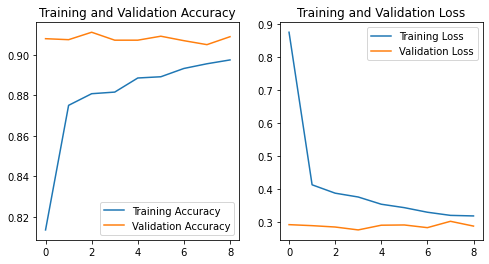

Wall time: 41.6 s


In [65]:
%%time
model_InceptionResNetV2_02,image_gen_train_InceptionResNetV2_02,image_gen_test_InceptionResNetV2_02 = process_models(model_base_InceptionResNetV2_02, predictions_InceptionResNetV2_02 , 
                                                                                                                     preprocess_input_InceptionResNetV2 )

img_shape = (299,299,3)
try:
    transfert_InceptionResNetV2_02 , score_transfert_InceptionResNetV2_02 = fit_model(model_InceptionResNetV2_02, 'transfert_InceptionResNetV2_02',
                                                                                  img_shape,image_gen_train_InceptionResNetV2_02,
                                                                                  image_gen_test_InceptionResNetV2_02)
except:
    transfert_InceptionResNetV2_02 = load_model(models_path+'transfert_InceptionResNetV2_02')
    score_transfert_InceptionResNetV2_02 = load(results_path+'score_transfert_InceptionResNetV2_02.joblib')
    transfert_InceptionResNetV2_02.summary()
    plot_metrics(score_transfert_InceptionResNetV2_02)

<p STYLE="padding-left:1em ; color:blue;text-align: justify;"><b> L'ajout de la couche de <span STYLE="color:gray;"><i> Dropout </i></span> n'améliore pas les prédictions.

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_303 (Conv2D)            (None, 149, 149, 32  864         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_307 (Batch  (None, 149, 149, 32  96         ['conv2d_303[0][0]']             
 Normalization)                 )                                                           

 conv2d_314 (Conv2D)            (None, 35, 35, 64)   12288       ['average_pooling2d_10[0][0]']   
                                                                                                  
 batch_normalization_312 (Batch  (None, 35, 35, 96)  288         ['conv2d_308[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_314 (Batch  (None, 35, 35, 64)  192         ['conv2d_310[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_317 (Batch  (None, 35, 35, 96)  288         ['conv2d_313[0][0]']             
 Normalization)                                                                                   
          

 Normalization)                                                                                   
                                                                                                  
 activation_318 (Activation)    (None, 35, 35, 32)   0           ['batch_normalization_328[0][0]']
                                                                                                  
 conv2d_322 (Conv2D)            (None, 35, 35, 32)   10240       ['block35_1_ac[0][0]']           
                                                                                                  
 conv2d_325 (Conv2D)            (None, 35, 35, 48)   13824       ['activation_318[0][0]']         
                                                                                                  
 batch_normalization_326 (Batch  (None, 35, 35, 32)  96          ['conv2d_322[0][0]']             
 Normalization)                                                                                   
          

 batch_normalization_336 (Batch  (None, 35, 35, 64)  192         ['conv2d_332[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_321 (Activation)    (None, 35, 35, 32)   0           ['batch_normalization_331[0][0]']
                                                                                                  
 activation_323 (Activation)    (None, 35, 35, 32)   0           ['batch_normalization_333[0][0]']
                                                                                                  
 activation_326 (Activation)    (None, 35, 35, 64)   0           ['batch_normalization_336[0][0]']
                                                                                                  
 block35_3_mixed (Concatenate)  (None, 35, 35, 128)  0           ['activation_321[0][0]',         
          

                                                                                                  
 batch_normalization_344 (Batch  (None, 35, 35, 32)  96          ['conv2d_340[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_347 (Batch  (None, 35, 35, 48)  144         ['conv2d_343[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_334 (Activation)    (None, 35, 35, 32)   0           ['batch_normalization_344[0][0]']
                                                                                                  
 activation_337 (Activation)    (None, 35, 35, 48)   0           ['batch_normalization_347[0][0]']
          

 activation_344 (Activation)    (None, 35, 35, 64)   0           ['batch_normalization_354[0][0]']
                                                                                                  
 block35_6_mixed (Concatenate)  (None, 35, 35, 128)  0           ['activation_339[0][0]',         
                                                                  'activation_341[0][0]',         
                                                                  'activation_344[0][0]']         
                                                                                                  
 block35_6_conv (Conv2D)        (None, 35, 35, 320)  41280       ['block35_6_mixed[0][0]']        
                                                                                                  
 block35_6 (Lambda)             (None, 35, 35, 320)  0           ['block35_5_ac[0][0]',           
                                                                  'block35_6_conv[0][0]']         
          

 activation_352 (Activation)    (None, 35, 35, 32)   0           ['batch_normalization_362[0][0]']
                                                                                                  
 activation_355 (Activation)    (None, 35, 35, 48)   0           ['batch_normalization_365[0][0]']
                                                                                                  
 conv2d_357 (Conv2D)            (None, 35, 35, 32)   10240       ['block35_7_ac[0][0]']           
                                                                                                  
 conv2d_359 (Conv2D)            (None, 35, 35, 32)   9216        ['activation_352[0][0]']         
                                                                                                  
 conv2d_362 (Conv2D)            (None, 35, 35, 64)   27648       ['activation_355[0][0]']         
                                                                                                  
 batch_nor

                                                                                                  
 block35_9 (Lambda)             (None, 35, 35, 320)  0           ['block35_8_ac[0][0]',           
                                                                  'block35_9_conv[0][0]']         
                                                                                                  
 block35_9_ac (Activation)      (None, 35, 35, 320)  0           ['block35_9[0][0]']              
                                                                                                  
 conv2d_372 (Conv2D)            (None, 35, 35, 32)   10240       ['block35_9_ac[0][0]']           
                                                                                                  
 batch_normalization_376 (Batch  (None, 35, 35, 32)  96          ['conv2d_372[0][0]']             
 Normalization)                                                                                   
          

 activation_369 (Activation)    (None, 17, 17, 384)  0           ['batch_normalization_379[0][0]']
                                                                                                  
 activation_372 (Activation)    (None, 17, 17, 384)  0           ['batch_normalization_382[0][0]']
                                                                                                  
 max_pooling2d_16 (MaxPooling2D  (None, 17, 17, 320)  0          ['block35_10_ac[0][0]']          
 )                                                                                                
                                                                                                  
 mixed_6a (Concatenate)         (None, 17, 17, 1088  0           ['activation_369[0][0]',         
                                )                                 'activation_372[0][0]',         
                                                                  'max_pooling2d_16[0][0]']       
          

                                )                                                                 
                                                                                                  
 block17_2 (Lambda)             (None, 17, 17, 1088  0           ['block17_1_ac[0][0]',           
                                )                                 'block17_2_conv[0][0]']         
                                                                                                  
 block17_2_ac (Activation)      (None, 17, 17, 1088  0           ['block17_2[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_388 (Conv2D)            (None, 17, 17, 128)  139264      ['block17_2_ac[0][0]']           
                                                                                                  
 batch_nor

                                )                                 'block17_4_conv[0][0]']         
                                                                                                  
 block17_4_ac (Activation)      (None, 17, 17, 1088  0           ['block17_4[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_396 (Conv2D)            (None, 17, 17, 128)  139264      ['block17_4_ac[0][0]']           
                                                                                                  
 batch_normalization_400 (Batch  (None, 17, 17, 128)  384        ['conv2d_396[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

                                )                                                                 
                                                                                                  
 conv2d_404 (Conv2D)            (None, 17, 17, 128)  139264      ['block17_6_ac[0][0]']           
                                                                                                  
 batch_normalization_408 (Batch  (None, 17, 17, 128)  384        ['conv2d_404[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_398 (Activation)    (None, 17, 17, 128)  0           ['batch_normalization_408[0][0]']
                                                                                                  
 conv2d_405 (Conv2D)            (None, 17, 17, 160)  143360      ['activation_398[0][0]']         
          

                                                                                                  
 batch_normalization_416 (Batch  (None, 17, 17, 128)  384        ['conv2d_412[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_406 (Activation)    (None, 17, 17, 128)  0           ['batch_normalization_416[0][0]']
                                                                                                  
 conv2d_413 (Conv2D)            (None, 17, 17, 160)  143360      ['activation_406[0][0]']         
                                                                                                  
 batch_normalization_417 (Batch  (None, 17, 17, 160)  480        ['conv2d_413[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 activation_414 (Activation)    (None, 17, 17, 128)  0           ['batch_normalization_424[0][0]']
                                                                                                  
 conv2d_421 (Conv2D)            (None, 17, 17, 160)  143360      ['activation_414[0][0]']         
                                                                                                  
 batch_normalization_425 (Batch  (None, 17, 17, 160)  480        ['conv2d_421[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_415 (Activation)    (None, 17, 17, 160)  0           ['batch_normalization_425[0][0]']
                                                                                                  
 conv2d_41

 conv2d_429 (Conv2D)            (None, 17, 17, 160)  143360      ['activation_422[0][0]']         
                                                                                                  
 batch_normalization_433 (Batch  (None, 17, 17, 160)  480        ['conv2d_429[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_423 (Activation)    (None, 17, 17, 160)  0           ['batch_normalization_433[0][0]']
                                                                                                  
 conv2d_427 (Conv2D)            (None, 17, 17, 192)  208896      ['block17_12_ac[0][0]']          
                                                                                                  
 conv2d_430 (Conv2D)            (None, 17, 17, 192)  215040      ['activation_423[0][0]']         
          

 Normalization)                                                                                   
                                                                                                  
 activation_431 (Activation)    (None, 17, 17, 160)  0           ['batch_normalization_441[0][0]']
                                                                                                  
 conv2d_435 (Conv2D)            (None, 17, 17, 192)  208896      ['block17_14_ac[0][0]']          
                                                                                                  
 conv2d_438 (Conv2D)            (None, 17, 17, 192)  215040      ['activation_431[0][0]']         
                                                                                                  
 batch_normalization_439 (Batch  (None, 17, 17, 192)  576        ['conv2d_435[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 conv2d_443 (Conv2D)            (None, 17, 17, 192)  208896      ['block17_16_ac[0][0]']          
                                                                                                  
 conv2d_446 (Conv2D)            (None, 17, 17, 192)  215040      ['activation_439[0][0]']         
                                                                                                  
 batch_normalization_447 (Batch  (None, 17, 17, 192)  576        ['conv2d_443[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_450 (Batch  (None, 17, 17, 192)  576        ['conv2d_446[0][0]']             
 Normalization)                                                                                   
          

 conv2d_454 (Conv2D)            (None, 17, 17, 192)  215040      ['activation_447[0][0]']         
                                                                                                  
 batch_normalization_455 (Batch  (None, 17, 17, 192)  576        ['conv2d_451[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_458 (Batch  (None, 17, 17, 192)  576        ['conv2d_454[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_445 (Activation)    (None, 17, 17, 192)  0           ['batch_normalization_455[0][0]']
                                                                                                  
 activatio

 batch_normalization_468 (Batch  (None, 17, 17, 288)  864        ['conv2d_464[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_453 (Activation)    (None, 17, 17, 256)  0           ['batch_normalization_463[0][0]']
                                                                                                  
 activation_455 (Activation)    (None, 17, 17, 256)  0           ['batch_normalization_465[0][0]']
                                                                                                  
 activation_458 (Activation)    (None, 17, 17, 288)  0           ['batch_normalization_468[0][0]']
                                                                                                  
 conv2d_460 (Conv2D)            (None, 8, 8, 384)    884736      ['activation_453[0][0]']         
          

 conv2d_472 (Conv2D)            (None, 8, 8, 224)    129024      ['activation_465[0][0]']         
                                                                                                  
 batch_normalization_476 (Batch  (None, 8, 8, 224)   672         ['conv2d_472[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_466 (Activation)    (None, 8, 8, 224)    0           ['batch_normalization_476[0][0]']
                                                                                                  
 conv2d_470 (Conv2D)            (None, 8, 8, 192)    399360      ['block8_1_ac[0][0]']            
                                                                                                  
 conv2d_473 (Conv2D)            (None, 8, 8, 256)    172032      ['activation_466[0][0]']         
          

 conv2d_478 (Conv2D)            (None, 8, 8, 192)    399360      ['block8_3_ac[0][0]']            
                                                                                                  
 conv2d_481 (Conv2D)            (None, 8, 8, 256)    172032      ['activation_474[0][0]']         
                                                                                                  
 batch_normalization_482 (Batch  (None, 8, 8, 192)   576         ['conv2d_478[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_485 (Batch  (None, 8, 8, 256)   768         ['conv2d_481[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

 batch_normalization_493 (Batch  (None, 8, 8, 256)   768         ['conv2d_489[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_480 (Activation)    (None, 8, 8, 192)    0           ['batch_normalization_490[0][0]']
                                                                                                  
 activation_483 (Activation)    (None, 8, 8, 256)    0           ['batch_normalization_493[0][0]']
                                                                                                  
 block8_6_mixed (Concatenate)   (None, 8, 8, 448)    0           ['activation_480[0][0]',         
                                                                  'activation_483[0][0]']         
                                                                                                  
 block8_6_

 block8_8_mixed (Concatenate)   (None, 8, 8, 448)    0           ['activation_488[0][0]',         
                                                                  'activation_491[0][0]']         
                                                                                                  
 block8_8_conv (Conv2D)         (None, 8, 8, 2080)   933920      ['block8_8_mixed[0][0]']         
                                                                                                  
 block8_8 (Lambda)              (None, 8, 8, 2080)   0           ['block8_7_ac[0][0]',            
                                                                  'block8_8_conv[0][0]']          
                                                                                                  
 block8_8_ac (Activation)       (None, 8, 8, 2080)   0           ['block8_8[0][0]']               
                                                                                                  
 conv2d_49

                                                                                                  
 conv_7b (Conv2D)               (None, 8, 8, 1536)   3194880     ['block8_10[0][0]']              
                                                                                                  
 conv_7b_bn (BatchNormalization  (None, 8, 8, 1536)  4608        ['conv_7b[0][0]']                
 )                                                                                                
                                                                                                  
 conv_7b_ac (Activation)        (None, 8, 8, 1536)   0           ['conv_7b_bn[0][0]']             
                                                                                                  
 global_average_pooling2d_2 (Gl  (None, 1536)        0           ['conv_7b_ac[0][0]']             
 obalAveragePooling2D)                                                                            
          

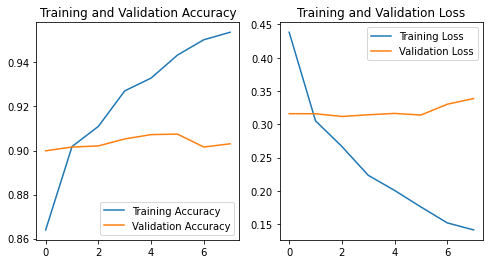

Wall time: 49.6 s


In [66]:
%%time
model_base_InceptionResNetV2_02.trainable = True
transfert_InceptionResNetV2_02.compile(optimizer=keras.optimizers.Adam(1e-5),# Low learning rate
                                    loss='categorical_crossentropy',metrics=['accuracy'])

img_shape = (299,299,3)
try:
    transfert_InceptionResNetV2_ajust_02 , score_transfert_InceptionResNetV2_ajust_02 = fit_model(transfert_InceptionResNetV2_02, 'transfert_InceptionResNetV2_ajust_02',  img_shape,
                                                                                        image_gen_train_InceptionResNetV2_02 , image_gen_test_InceptionResNetV2_02)
except:
    transfert_InceptionResNetV2_ajust_02 = load_model(models_path+'transfert_InceptionResNetV2_ajust_02')
    score_transfert_InceptionResNetV2_ajust_02 = load(results_path+'score_transfert_InceptionResNetV2_ajust_02.joblib')
    transfert_InceptionResNetV2_ajust_02.summary()
    plot_metrics(score_transfert_InceptionResNetV2_ajust_02)


<p STYLE="padding-left:1em ; color:blue;text-align: justify;"><b> Le réglage fin des différents paramètres induit une hausse du surajustement.

## <a STYLE="color:black" id="4.4">4.4 Modèle InceptionV3</a> 

In [67]:
from keras.applications.inception_v3 import InceptionV3,  preprocess_input,  decode_predictions

img_shape = (299,299,3)
new_imput = keras.Input(shape=(299,299,3))

preprocess_input_inceptionV3 = preprocess_input
decode_predictions_inceptionV3 = decode_predictions

model_base_inceptionV3 = InceptionV3(weights="imagenet", include_top=False,input_tensor=new_imput,input_shape=img_shape )
model_base_inceptionV3.trainable = False
model_base_inceptionV3.summary()

x_inceptionV3 = GlobalAveragePooling2D()(model_base_inceptionV3.output)
predictions_inceptionV3 = Dense(num_class, activation='softmax')(x_inceptionV3)

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_406 (Conv2D)            (None, 149, 149, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_406 (Batch  (None, 149, 149, 32  96         ['conv2d_406[0][0]']             
 Normalization)                 )                                                      

 batch_normalization_411 (Batch  (None, 35, 35, 64)  192         ['conv2d_411[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_413 (Batch  (None, 35, 35, 64)  192         ['conv2d_413[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_416 (Batch  (None, 35, 35, 96)  288         ['conv2d_416[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_417 (Batch  (None, 35, 35, 32)  96          ['conv2d_417[0][0]']             
 Normaliza

                                                                                                  
 batch_normalization_428 (Batch  (None, 35, 35, 64)  192         ['conv2d_428[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_428 (Activation)    (None, 35, 35, 64)   0           ['batch_normalization_428[0][0]']
                                                                                                  
 conv2d_426 (Conv2D)            (None, 35, 35, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_429 (Conv2D)            (None, 35, 35, 96)   55296       ['activation_428[0][0]']         
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_10 (MaxPooling2D  (None, 17, 17, 288)  0          ['mixed2[0][0]']                 
 )                                                                                                
                                                                                                  
 mixed3 (Concatenate)           (None, 17, 17, 768)  0           ['activation_432[0][0]',         
                                                                  'activation_435[0][0]',         
                                                                  'max_pooling2d_10[0][0]']       
                                                                                                  
 conv2d_440 (Conv2D)            (None, 17, 17, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_nor

                                                                  'activation_444[0][0]',         
                                                                  'activation_445[0][0]']         
                                                                                                  
 conv2d_450 (Conv2D)            (None, 17, 17, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_450 (Batch  (None, 17, 17, 160)  480        ['conv2d_450[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_450 (Activation)    (None, 17, 17, 160)  0           ['batch_normalization_450[0][0]']
                                                                                                  
 conv2d_45

 batch_normalization_460 (Batch  (None, 17, 17, 160)  480        ['conv2d_460[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_460 (Activation)    (None, 17, 17, 160)  0           ['batch_normalization_460[0][0]']
                                                                                                  
 conv2d_461 (Conv2D)            (None, 17, 17, 160)  179200      ['activation_460[0][0]']         
                                                                                                  
 batch_normalization_461 (Batch  (None, 17, 17, 160)  480        ['conv2d_461[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

 conv2d_471 (Conv2D)            (None, 17, 17, 192)  258048      ['activation_470[0][0]']         
                                                                                                  
 batch_normalization_471 (Batch  (None, 17, 17, 192)  576        ['conv2d_471[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_471 (Activation)    (None, 17, 17, 192)  0           ['batch_normalization_471[0][0]']
                                                                                                  
 conv2d_467 (Conv2D)            (None, 17, 17, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_472 (Conv2D)            (None, 17, 17, 192)  258048      ['activation_471[0][0]']         
          

 activation_479 (Activation)    (None, 17, 17, 192)  0           ['batch_normalization_479[0][0]']
                                                                                                  
 conv2d_476 (Conv2D)            (None, 17, 17, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_480 (Conv2D)            (None, 17, 17, 192)  258048      ['activation_479[0][0]']         
                                                                                                  
 batch_normalization_476 (Batch  (None, 17, 17, 192)  576        ['conv2d_476[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_480 (Batch  (None, 17, 17, 192)  576        ['conv2d_480[0][0]']             
 Normaliza

 conv2d_490 (Conv2D)            (None, 8, 8, 192)    245760      ['average_pooling2d_9[0][0]']    
                                                                                                  
 batch_normalization_482 (Batch  (None, 8, 8, 320)   960         ['conv2d_482[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_484 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_484[0][0]']
                                                                                                  
 activation_485 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_485[0][0]']
                                                                                                  
 activation_488 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_488[0][0]']
          

                                                                                                  
 activation_494 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_494[0][0]']
                                                                                                  
 activation_497 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_497[0][0]']
                                                                                                  
 activation_498 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_498[0][0]']
                                                                                                  
 batch_normalization_499 (Batch  (None, 8, 8, 192)   576         ['conv2d_499[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 149, 149, 32  864         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_10 (BatchN  (None, 149, 149, 32  96         ['conv2d_6[0][0]']               
 ormalization)                  )                                                           

 batch_normalization_15 (BatchN  (None, 35, 35, 64)  192         ['conv2d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_17 (BatchN  (None, 35, 35, 64)  192         ['conv2d_13[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_20 (BatchN  (None, 35, 35, 96)  288         ['conv2d_16[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_21 (BatchN  (None, 35, 35, 32)  96          ['conv2d_17[0][0]']              
 ormalizat

                                                                                                  
 batch_normalization_32 (BatchN  (None, 35, 35, 64)  192         ['conv2d_28[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 35, 35, 64)   0           ['batch_normalization_32[0][0]'] 
                                                                                                  
 conv2d_26 (Conv2D)             (None, 35, 35, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_29 (Conv2D)             (None, 35, 35, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_8 (MaxPooling2D)  (None, 17, 17, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 17, 17, 768)  0           ['activation_26[0][0]',          
                                                                  'activation_29[0][0]',          
                                                                  'max_pooling2d_8[0][0]']        
                                                                                                  
 conv2d_40 (Conv2D)             (None, 17, 17, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_44 (BatchN  (None, 17, 17, 128)  384        ['conv2d_40[0][0]']              
 ormalizat

                                                                  'activation_39[0][0]']          
                                                                                                  
 conv2d_50 (Conv2D)             (None, 17, 17, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_54 (BatchN  (None, 17, 17, 160)  480        ['conv2d_50[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_44 (Activation)     (None, 17, 17, 160)  0           ['batch_normalization_54[0][0]'] 
                                                                                                  
 conv2d_51 (Conv2D)             (None, 17, 17, 160)  179200      ['activation_44[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 activation_54 (Activation)     (None, 17, 17, 160)  0           ['batch_normalization_64[0][0]'] 
                                                                                                  
 conv2d_61 (Conv2D)             (None, 17, 17, 160)  179200      ['activation_54[0][0]']          
                                                                                                  
 batch_normalization_65 (BatchN  (None, 17, 17, 160)  480        ['conv2d_61[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 17, 17, 160)  0           ['batch_normalization_65[0][0]'] 
          

                                                                                                  
 batch_normalization_75 (BatchN  (None, 17, 17, 192)  576        ['conv2d_71[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 17, 17, 192)  0           ['batch_normalization_75[0][0]'] 
                                                                                                  
 conv2d_67 (Conv2D)             (None, 17, 17, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_72 (Conv2D)             (None, 17, 17, 192)  258048      ['activation_65[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_76 (Conv2D)             (None, 17, 17, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_80 (Conv2D)             (None, 17, 17, 192)  258048      ['activation_73[0][0]']          
                                                                                                  
 batch_normalization_80 (BatchN  (None, 17, 17, 192)  576        ['conv2d_76[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_84 (BatchN  (None, 17, 17, 192)  576        ['conv2d_80[0][0]']              
 ormalization)                                                                                    
          

 batch_normalization_86 (BatchN  (None, 8, 8, 320)   960         ['conv2d_82[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_78 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_88[0][0]'] 
                                                                                                  
 activation_79 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_89[0][0]'] 
                                                                                                  
 activation_82 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_92[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_93[0][0]'] 
          

                                                                                                  
 activation_91 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_101[0][0]']
                                                                                                  
 activation_92 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_102[0][0]']
                                                                                                  
 batch_normalization_103 (Batch  (None, 8, 8, 192)   576         ['conv2d_99[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation_85 (Activation)     (None, 8, 8, 320)    0           ['batch_normalization_95[0][0]'] 
                                                                                                  
 mixed9_1 

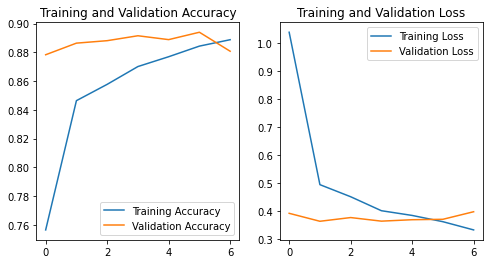

Wall time: 5.03 s


In [68]:
%%time
model_inceptionV3,image_gen_train_inceptionV3,image_gen_test_inceptionV3 = process_models(model_base_inceptionV3, predictions_inceptionV3 , preprocess_input_inceptionV3 )

img_shape = (299,299,3)
transfert_inceptionV3 , score_transfert_inceptionV3 = fit_model(model_inceptionV3, 'transfert_inceptionV3', img_shape,
                                                    image_gen_train_inceptionV3 , image_gen_test_inceptionV3)

<p STYLE="padding-left:1em ; color:blue;text-align: justify;"><b> Nous observons de bonnes prédictions avec ce modèle, similaire à ceux obtenus précédément.

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_203 (Conv2D)            (None, 149, 149, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_203 (Batch  (None, 149, 149, 32  96         ['conv2d_203[0][0]']             
 Normalization)                 )                                                           

 batch_normalization_208 (Batch  (None, 35, 35, 64)  192         ['conv2d_208[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_210 (Batch  (None, 35, 35, 64)  192         ['conv2d_210[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_213 (Batch  (None, 35, 35, 96)  288         ['conv2d_213[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_214 (Batch  (None, 35, 35, 32)  96          ['conv2d_214[0][0]']             
 Normaliza

                                                                                                  
 batch_normalization_225 (Batch  (None, 35, 35, 64)  192         ['conv2d_225[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_225 (Activation)    (None, 35, 35, 64)   0           ['batch_normalization_225[0][0]']
                                                                                                  
 conv2d_223 (Conv2D)            (None, 35, 35, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_226 (Conv2D)            (None, 35, 35, 96)   55296       ['activation_225[0][0]']         
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 17, 17, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 17, 17, 768)  0           ['activation_229[0][0]',         
                                                                  'activation_232[0][0]',         
                                                                  'max_pooling2d_6[0][0]']        
                                                                                                  
 conv2d_237 (Conv2D)            (None, 17, 17, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_237 (Batch  (None, 17, 17, 128)  384        ['conv2d_237[0][0]']             
 Normaliza

                                                                  'activation_242[0][0]']         
                                                                                                  
 conv2d_247 (Conv2D)            (None, 17, 17, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_247 (Batch  (None, 17, 17, 160)  480        ['conv2d_247[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_247 (Activation)    (None, 17, 17, 160)  0           ['batch_normalization_247[0][0]']
                                                                                                  
 conv2d_248 (Conv2D)            (None, 17, 17, 160)  179200      ['activation_247[0][0]']         
          

 Normalization)                                                                                   
                                                                                                  
 activation_257 (Activation)    (None, 17, 17, 160)  0           ['batch_normalization_257[0][0]']
                                                                                                  
 conv2d_258 (Conv2D)            (None, 17, 17, 160)  179200      ['activation_257[0][0]']         
                                                                                                  
 batch_normalization_258 (Batch  (None, 17, 17, 160)  480        ['conv2d_258[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_258 (Activation)    (None, 17, 17, 160)  0           ['batch_normalization_258[0][0]']
          

                                                                                                  
 batch_normalization_268 (Batch  (None, 17, 17, 192)  576        ['conv2d_268[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_268 (Activation)    (None, 17, 17, 192)  0           ['batch_normalization_268[0][0]']
                                                                                                  
 conv2d_264 (Conv2D)            (None, 17, 17, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_269 (Conv2D)            (None, 17, 17, 192)  258048      ['activation_268[0][0]']         
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_273 (Conv2D)            (None, 17, 17, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_277 (Conv2D)            (None, 17, 17, 192)  258048      ['activation_276[0][0]']         
                                                                                                  
 batch_normalization_273 (Batch  (None, 17, 17, 192)  576        ['conv2d_273[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_277 (Batch  (None, 17, 17, 192)  576        ['conv2d_277[0][0]']             
 Normalization)                                                                                   
          

 batch_normalization_279 (Batch  (None, 8, 8, 320)   960         ['conv2d_279[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_281 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_281[0][0]']
                                                                                                  
 activation_282 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_282[0][0]']
                                                                                                  
 activation_285 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_285[0][0]']
                                                                                                  
 activation_286 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_286[0][0]']
          

                                                                                                  
 activation_294 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_294[0][0]']
                                                                                                  
 activation_295 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_295[0][0]']
                                                                                                  
 batch_normalization_296 (Batch  (None, 8, 8, 192)   576         ['conv2d_296[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_288 (Activation)    (None, 8, 8, 320)    0           ['batch_normalization_288[0][0]']
                                                                                                  
 mixed9_1 

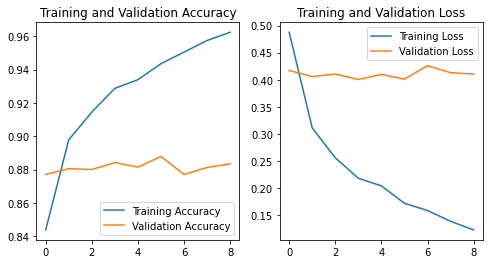

Wall time: 7.21 s


In [69]:
%%time
model_base_inceptionV3.trainable = True
transfert_inceptionV3.compile(optimizer=keras.optimizers.Adam(1e-5),# Low learning rate
                    loss='categorical_crossentropy',metrics=['accuracy'])

img_shape = (299,299,3)
transfert_inceptionV3_ajust , score_transfert_inceptionV3_ajust = fit_model(transfert_inceptionV3, 'transfert_inceptionV3_ajust', img_shape,
                                                    image_gen_train_inceptionV3 , image_gen_test_inceptionV3)

<p STYLE="padding-left:1em ; color:blue;text-align: justify;"><b> L'entrainement fin du modèle ne permet pas d'améliorer les prédictions où nous voyons une hausse du sur-apprentissage.

In [70]:
model_base_inceptionV3_02 = InceptionV3(weights="imagenet", include_top=False,input_tensor=new_imput,input_shape=img_shape )
model_base_inceptionV3_02.trainable = False
model_base_inceptionV3_02.summary()

x_inceptionV3_02 = GlobalAveragePooling2D()(model_base_inceptionV3_02.output)
x_inceptionV3_02 = keras.layers.Dropout(0.3)(x_inceptionV3_02) 
predictions_inceptionV3_02 = Dense(num_class, activation='softmax')(x_inceptionV3_02)


Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_500 (Conv2D)            (None, 149, 149, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_500 (Batch  (None, 149, 149, 32  96         ['conv2d_500[0][0]']             
 Normalization)                 )                                                      

 conv2d_511 (Conv2D)            (None, 35, 35, 32)   6144        ['average_pooling2d_11[0][0]']   
                                                                                                  
 batch_normalization_505 (Batch  (None, 35, 35, 64)  192         ['conv2d_505[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_507 (Batch  (None, 35, 35, 64)  192         ['conv2d_507[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_510 (Batch  (None, 35, 35, 96)  288         ['conv2d_510[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 conv2d_522 (Conv2D)            (None, 35, 35, 64)   18432       ['mixed1[0][0]']                 
                                                                                                  
 batch_normalization_522 (Batch  (None, 35, 35, 64)  192         ['conv2d_522[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_522 (Activation)    (None, 35, 35, 64)   0           ['batch_normalization_522[0][0]']
                                                                                                  
 conv2d_520 (Conv2D)            (None, 35, 35, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_52

                                                                                                  
 activation_529 (Activation)    (None, 17, 17, 96)   0           ['batch_normalization_529[0][0]']
                                                                                                  
 max_pooling2d_14 (MaxPooling2D  (None, 17, 17, 288)  0          ['mixed2[0][0]']                 
 )                                                                                                
                                                                                                  
 mixed3 (Concatenate)           (None, 17, 17, 768)  0           ['activation_526[0][0]',         
                                                                  'activation_529[0][0]',         
                                                                  'max_pooling2d_14[0][0]']       
                                                                                                  
 conv2d_53

 mixed4 (Concatenate)           (None, 17, 17, 768)  0           ['activation_530[0][0]',         
                                                                  'activation_533[0][0]',         
                                                                  'activation_538[0][0]',         
                                                                  'activation_539[0][0]']         
                                                                                                  
 conv2d_544 (Conv2D)            (None, 17, 17, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_544 (Batch  (None, 17, 17, 160)  480        ['conv2d_544[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

 conv2d_554 (Conv2D)            (None, 17, 17, 160)  122880      ['mixed5[0][0]']                 
                                                                                                  
 batch_normalization_554 (Batch  (None, 17, 17, 160)  480        ['conv2d_554[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_554 (Activation)    (None, 17, 17, 160)  0           ['batch_normalization_554[0][0]']
                                                                                                  
 conv2d_555 (Conv2D)            (None, 17, 17, 160)  179200      ['activation_554[0][0]']         
                                                                                                  
 batch_normalization_555 (Batch  (None, 17, 17, 160)  480        ['conv2d_555[0][0]']             
 Normaliza

 activation_564 (Activation)    (None, 17, 17, 192)  0           ['batch_normalization_564[0][0]']
                                                                                                  
 conv2d_565 (Conv2D)            (None, 17, 17, 192)  258048      ['activation_564[0][0]']         
                                                                                                  
 batch_normalization_565 (Batch  (None, 17, 17, 192)  576        ['conv2d_565[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_565 (Activation)    (None, 17, 17, 192)  0           ['batch_normalization_565[0][0]']
                                                                                                  
 conv2d_561 (Conv2D)            (None, 17, 17, 192)  147456      ['mixed6[0][0]']                 
          

 Normalization)                                                                                   
                                                                                                  
 activation_573 (Activation)    (None, 17, 17, 192)  0           ['batch_normalization_573[0][0]']
                                                                                                  
 conv2d_570 (Conv2D)            (None, 17, 17, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_574 (Conv2D)            (None, 17, 17, 192)  258048      ['activation_573[0][0]']         
                                                                                                  
 batch_normalization_570 (Batch  (None, 17, 17, 192)  576        ['conv2d_570[0][0]']             
 Normalization)                                                                                   
          

 Normalization)                                                                                   
                                                                                                  
 conv2d_584 (Conv2D)            (None, 8, 8, 192)    245760      ['average_pooling2d_18[0][0]']   
                                                                                                  
 batch_normalization_576 (Batch  (None, 8, 8, 320)   960         ['conv2d_576[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_578 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_578[0][0]']
                                                                                                  
 activation_579 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_579[0][0]']
          

                                                                                                  
 activation_587 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_587[0][0]']
                                                                                                  
 activation_588 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_588[0][0]']
                                                                                                  
 activation_591 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_591[0][0]']
                                                                                                  
 activation_592 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_592[0][0]']
                                                                                                  
 batch_normalization_593 (Batch  (None, 8, 8, 192)   576         ['conv2d_593[0][0]']             
 Normaliza

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_502 (Conv2D)            (None, 149, 149, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_500 (Batch  (None, 149, 149, 32  96         ['conv2d_502[0][0]']             
 Normalization)                 )                                                           

 conv2d_513 (Conv2D)            (None, 35, 35, 32)   6144        ['average_pooling2d_11[0][0]']   
                                                                                                  
 batch_normalization_505 (Batch  (None, 35, 35, 64)  192         ['conv2d_507[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_507 (Batch  (None, 35, 35, 64)  192         ['conv2d_509[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_510 (Batch  (None, 35, 35, 96)  288         ['conv2d_512[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 conv2d_524 (Conv2D)            (None, 35, 35, 64)   18432       ['mixed1[0][0]']                 
                                                                                                  
 batch_normalization_522 (Batch  (None, 35, 35, 64)  192         ['conv2d_524[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_522 (Activation)    (None, 35, 35, 64)   0           ['batch_normalization_522[0][0]']
                                                                                                  
 conv2d_522 (Conv2D)            (None, 35, 35, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_52

                                                                                                  
 activation_529 (Activation)    (None, 17, 17, 96)   0           ['batch_normalization_529[0][0]']
                                                                                                  
 max_pooling2d_16 (MaxPooling2D  (None, 17, 17, 288)  0          ['mixed2[0][0]']                 
 )                                                                                                
                                                                                                  
 mixed3 (Concatenate)           (None, 17, 17, 768)  0           ['activation_526[0][0]',         
                                                                  'activation_529[0][0]',         
                                                                  'max_pooling2d_16[0][0]']       
                                                                                                  
 conv2d_53

 mixed4 (Concatenate)           (None, 17, 17, 768)  0           ['activation_530[0][0]',         
                                                                  'activation_533[0][0]',         
                                                                  'activation_538[0][0]',         
                                                                  'activation_539[0][0]']         
                                                                                                  
 conv2d_546 (Conv2D)            (None, 17, 17, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_544 (Batch  (None, 17, 17, 160)  480        ['conv2d_546[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

 conv2d_556 (Conv2D)            (None, 17, 17, 160)  122880      ['mixed5[0][0]']                 
                                                                                                  
 batch_normalization_554 (Batch  (None, 17, 17, 160)  480        ['conv2d_556[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_554 (Activation)    (None, 17, 17, 160)  0           ['batch_normalization_554[0][0]']
                                                                                                  
 conv2d_557 (Conv2D)            (None, 17, 17, 160)  179200      ['activation_554[0][0]']         
                                                                                                  
 batch_normalization_555 (Batch  (None, 17, 17, 160)  480        ['conv2d_557[0][0]']             
 Normaliza

 activation_564 (Activation)    (None, 17, 17, 192)  0           ['batch_normalization_564[0][0]']
                                                                                                  
 conv2d_567 (Conv2D)            (None, 17, 17, 192)  258048      ['activation_564[0][0]']         
                                                                                                  
 batch_normalization_565 (Batch  (None, 17, 17, 192)  576        ['conv2d_567[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_565 (Activation)    (None, 17, 17, 192)  0           ['batch_normalization_565[0][0]']
                                                                                                  
 conv2d_563 (Conv2D)            (None, 17, 17, 192)  147456      ['mixed6[0][0]']                 
          

 Normalization)                                                                                   
                                                                                                  
 activation_573 (Activation)    (None, 17, 17, 192)  0           ['batch_normalization_573[0][0]']
                                                                                                  
 conv2d_572 (Conv2D)            (None, 17, 17, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_576 (Conv2D)            (None, 17, 17, 192)  258048      ['activation_573[0][0]']         
                                                                                                  
 batch_normalization_570 (Batch  (None, 17, 17, 192)  576        ['conv2d_572[0][0]']             
 Normalization)                                                                                   
          

 Normalization)                                                                                   
                                                                                                  
 conv2d_586 (Conv2D)            (None, 8, 8, 192)    245760      ['average_pooling2d_18[0][0]']   
                                                                                                  
 batch_normalization_576 (Batch  (None, 8, 8, 320)   960         ['conv2d_578[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_578 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_578[0][0]']
                                                                                                  
 activation_579 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_579[0][0]']
          

                                                                                                  
 activation_587 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_587[0][0]']
                                                                                                  
 activation_588 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_588[0][0]']
                                                                                                  
 activation_591 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_591[0][0]']
                                                                                                  
 activation_592 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_592[0][0]']
                                                                                                  
 batch_normalization_593 (Batch  (None, 8, 8, 192)   576         ['conv2d_595[0][0]']             
 Normaliza

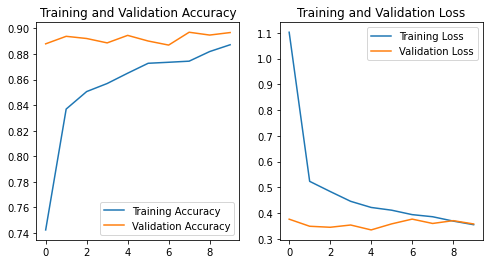

Wall time: 5.54 s


In [71]:
%%time
model_inceptionV3_02,image_gen_train_inceptionV3_02,image_gen_test_inceptionV3_02 = process_models(model_base_inceptionV3_02, predictions_inceptionV3_02 , 
                                                                                                                     preprocess_input_inceptionV3 )

img_shape = (299,299,3)
transfert_inceptionV3_02 , score_transfert_inceptionV3_02 = fit_model(model_inceptionV3_02, 'transfert_inceptionV3_02', img_shape,
                                                    image_gen_train_inceptionV3_02 , image_gen_test_inceptionV3_02)


<p STYLE="padding-left:1em ; color:blue;text-align: justify;"><b> L'ajout de la couche de <span STYLE="color:gray;"><i> Dropout </i></span> n'améliore pas les résultats. 

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_502 (Conv2D)            (None, 149, 149, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_500 (Batch  (None, 149, 149, 32  96         ['conv2d_502[0][0]']             
 Normalization)                 )                                                           

 conv2d_513 (Conv2D)            (None, 35, 35, 32)   6144        ['average_pooling2d_11[0][0]']   
                                                                                                  
 batch_normalization_505 (Batch  (None, 35, 35, 64)  192         ['conv2d_507[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_507 (Batch  (None, 35, 35, 64)  192         ['conv2d_509[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_510 (Batch  (None, 35, 35, 96)  288         ['conv2d_512[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 conv2d_524 (Conv2D)            (None, 35, 35, 64)   18432       ['mixed1[0][0]']                 
                                                                                                  
 batch_normalization_522 (Batch  (None, 35, 35, 64)  192         ['conv2d_524[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_522 (Activation)    (None, 35, 35, 64)   0           ['batch_normalization_522[0][0]']
                                                                                                  
 conv2d_522 (Conv2D)            (None, 35, 35, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_52

                                                                                                  
 activation_529 (Activation)    (None, 17, 17, 96)   0           ['batch_normalization_529[0][0]']
                                                                                                  
 max_pooling2d_16 (MaxPooling2D  (None, 17, 17, 288)  0          ['mixed2[0][0]']                 
 )                                                                                                
                                                                                                  
 mixed3 (Concatenate)           (None, 17, 17, 768)  0           ['activation_526[0][0]',         
                                                                  'activation_529[0][0]',         
                                                                  'max_pooling2d_16[0][0]']       
                                                                                                  
 conv2d_53

 mixed4 (Concatenate)           (None, 17, 17, 768)  0           ['activation_530[0][0]',         
                                                                  'activation_533[0][0]',         
                                                                  'activation_538[0][0]',         
                                                                  'activation_539[0][0]']         
                                                                                                  
 conv2d_546 (Conv2D)            (None, 17, 17, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_544 (Batch  (None, 17, 17, 160)  480        ['conv2d_546[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

 conv2d_556 (Conv2D)            (None, 17, 17, 160)  122880      ['mixed5[0][0]']                 
                                                                                                  
 batch_normalization_554 (Batch  (None, 17, 17, 160)  480        ['conv2d_556[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_554 (Activation)    (None, 17, 17, 160)  0           ['batch_normalization_554[0][0]']
                                                                                                  
 conv2d_557 (Conv2D)            (None, 17, 17, 160)  179200      ['activation_554[0][0]']         
                                                                                                  
 batch_normalization_555 (Batch  (None, 17, 17, 160)  480        ['conv2d_557[0][0]']             
 Normaliza

 activation_564 (Activation)    (None, 17, 17, 192)  0           ['batch_normalization_564[0][0]']
                                                                                                  
 conv2d_567 (Conv2D)            (None, 17, 17, 192)  258048      ['activation_564[0][0]']         
                                                                                                  
 batch_normalization_565 (Batch  (None, 17, 17, 192)  576        ['conv2d_567[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_565 (Activation)    (None, 17, 17, 192)  0           ['batch_normalization_565[0][0]']
                                                                                                  
 conv2d_563 (Conv2D)            (None, 17, 17, 192)  147456      ['mixed6[0][0]']                 
          

 Normalization)                                                                                   
                                                                                                  
 activation_573 (Activation)    (None, 17, 17, 192)  0           ['batch_normalization_573[0][0]']
                                                                                                  
 conv2d_572 (Conv2D)            (None, 17, 17, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_576 (Conv2D)            (None, 17, 17, 192)  258048      ['activation_573[0][0]']         
                                                                                                  
 batch_normalization_570 (Batch  (None, 17, 17, 192)  576        ['conv2d_572[0][0]']             
 Normalization)                                                                                   
          

 Normalization)                                                                                   
                                                                                                  
 conv2d_586 (Conv2D)            (None, 8, 8, 192)    245760      ['average_pooling2d_18[0][0]']   
                                                                                                  
 batch_normalization_576 (Batch  (None, 8, 8, 320)   960         ['conv2d_578[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_578 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_578[0][0]']
                                                                                                  
 activation_579 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_579[0][0]']
          

                                                                                                  
 activation_587 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_587[0][0]']
                                                                                                  
 activation_588 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_588[0][0]']
                                                                                                  
 activation_591 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_591[0][0]']
                                                                                                  
 activation_592 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_592[0][0]']
                                                                                                  
 batch_normalization_593 (Batch  (None, 8, 8, 192)   576         ['conv2d_595[0][0]']             
 Normaliza

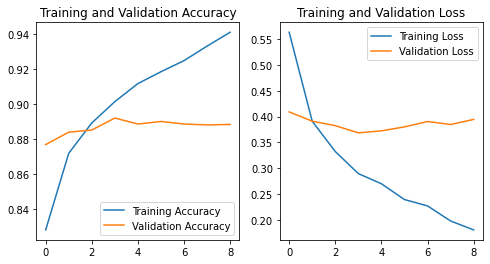

Wall time: 9.33 s


In [72]:
%%time
model_base_inceptionV3_02.trainable = True
transfert_inceptionV3_02.compile(optimizer=keras.optimizers.Adam(1e-5),# Low learning rate
                                    loss='categorical_crossentropy',metrics=['accuracy'])

img_shape = (299,299,3)
transfert_inceptionV3_ajust_02 , score_transfert_inceptionV3_ajust_02 = fit_model(transfert_inceptionV3_02, 'transfert_inceptionV3_ajust_02',  img_shape,
                                                                                        image_gen_train_inceptionV3_02 , image_gen_test_inceptionV3_02)

<p STYLE="padding-left:1em ; color:blue;text-align: justify;"><b> L'entrainement fin du modèle ne permet pas d'améliorer les prédictions où nous voyons une hausse du sur-apprentissage.

# <a STYLE="color:black" id="5">Etape 5 : Prédiction

"Image d'un affenpinscher"

"il s'agit d'un affenpinscher avec une probabilité de 97.98 %"

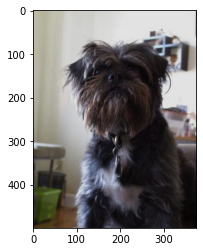

In [73]:
from keras.applications.inception_resnet_v2 import preprocess_input
model = load_model('./Models/transfert_InceptionResNetV2_ajust')
classes = load('./Models/classes_120.joblib')

for file_image in np.array([os.listdir(pred_path)[0]]):
    path_image = pred_path + '/'+ file_image

    # img = image.load_img(path_image, target_size=(299,299))
    img = image.load_img(path_image)
    plt.imshow(img)
    img = img.resize((299,299) )
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)


    pred = model.predict(img)
    nom = classes[np.argmax(pred)]
    percent = pred[0][np.argmax(pred)]
    display(f'Image d\'un {file_image.split()[0]}')
    display(f'il s\'agit d\'un {nom} avec une probabilité de {round(percent*100,2)} %')